## Table of Contents
<a href="#section1"> 1. Introduction </a>

<a href="#section2"> 2. Exploratory Data Analysis </a>
- <a href="#section2.1"> 2.1 Background Information about Attributes </a>
- <a href="#section2.2"> 2.2 Summary of Attributes </a>
- <a href="#section2.3"> 2.3 Summary of Findings from Distributions </a>
- <a href="#section2.4"> 2.4 Correlation Analysis Between Predictors </a>
- <a href="#section2.5"> 2.5 Summarising Results of Correlation between Predictors </a>
- <a href="#section2.6"> 2.6 Correlation Analysis Between Response and Predictors </a>
- <a href="#section2.7"> 2.7 Important Findings </a>

<a href="#section3"> 3. Regression Model Development </a>
- <a href="#section3.1"> 3.1 Stepwise Feature Selection with Cp, adj_R^2 and BIC </a>
- <a href="#section3.2"> 3.2 Ridge Regression (L1) </a>
- <a href="#section3.3"> 3.3 Lasso (L2) </a>
- <a href="#section3.4"> 3.4 Comparing Results of Stepwise Selections and Parameter Shrinkage </a>

<a href="#section4"> 4. XGBoost </a>
- <a href="#section4.1"> 4.1 Cross-Validation for XGBoost </a>
- <a href="#section4.2"> 4.2 XGBoost Hyper-Parameter Tuning with Grid-Search </a>
- <a href="#section4.3"> 4.3 Assessing Feature Importance </a>

<a href="#section5"> 5. Model Comparison </a>


***

<a id="section1"></a>
# 1. Introduction

This document includes the data analysis performed on several substances and their chemical properties. The aim is to build a  models to predict the critical temperature of substances.

The first part is exploratory data analysis. It aims to understand the data and relationships between variables. 

Second part explains the development of the model. It explains the decision made to increase the model performance and the evaluation of different options. There are 2 main models. A regression model developed with stepwise feature selection using BIC, Adjusted R^2 and C_p. Also, Ridge(L1) and Lasso(L2) versions are developed for the regression model. Best performing regression model out of these 5 is kept as a benchmark model.

Additionaly, XGBoost model is created after grid-searching for optimum hyperparameter values.

Also, for both XGBoost and Regression models, importance of parameters are assessed to understand factors affecting critical temperature of a superconductor.

Finally, resulting models are compared.


In [1]:
# Load Required Libraries
library(ggplot2)
library(reshape2)
library(stats)
library(scales)
library(grid)
library(gridExtra)
library(RColorBrewer)
library(dplyr)
library(leaps)
library(glmnet)
library(fmsb)
library(xgboost)
library(tidyverse)
library(dplyr)
library(caret)

# Load the datasets
data=read.csv("../input/super-conductors//train.csv")

# Load the datasets
nrow = dim(data)[1]
ncol = dim(data)[2]

# Divide dataset into test and train
set.seed(0)
test.index = sample(1:nrow, round(nrow/10), replace = FALSE)
train = data[-test.index, ]
test = data[test.index,]

# Divide dataframe
no_elements = data[,1]
atomic_mass = data[,2:11]
fie = data[,12:21]
atomic_radius = data[,22:31]
density = data[,32:41]
electron_aff = data[,42:51]
fusion_heat = data[,52:61]
thermal_cond = data[,62:71]
valance = data[,72:81]
critical_temp = data[,82]


Attaching package: ‘dplyr’


The following object is masked from ‘package:gridExtra’:

    combine


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: Matrix

Loaded glmnet 3.0-1



Attaching package: ‘xgboost’


The following object is masked from ‘package:dplyr’:

    slice


── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──

✔ tibble  2.1.3     ✔ purrr   0.3.3
✔ tidyr   1.0.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ readr::col_factor() masks scales::col_factor()
✖ dplyr::combine()    masks gridExtra::combine()
✖ purrr::discard()    masks scales::discard()
✖ tidyr::expand()     masks Matrix::expand()
✖ dplyr::filter()     masks stats::filter()
✖ dplyr::lag()        masks stats::lag()
✖ tidyr::pack()       masks

<a id="section2"></a>
## Background Information about Features

Except for number_of_elements and critical temperature; all of the variables are derived using mean, weighted mean, geometric mean, weighted geometric mean, standard deviation, weighted standard deviation, entropy, weighted entropy, range and weighted range calculations.

Most of the original features are continous variables due to their nature. For example; atomic mass, fie (possibly fie refers to First Ionisation Energy due to context), atomic radius, density, electron affinity, fusian heat, thermal conductivity, critical temperature. Only number of valance electrons is a dicrete variable though due to applied transformations such mean and weighted mean etc. derived versions of valance variable are mostly continous except for range_valance. Also, number of elements included in the material is a discrete variable.
<a id="section2"></a>
# 2. Exploratory Data Analysis
<a id="section2.1"></a>
## 2.1 Summary of Features
**THERE ARE TOTAL 81 FEATURES IN THE DATA, NOT ALL OF THEM WILL BE SUMMARISED HERE.**

### Number of Elements

__number_of_elements__: Mostly between 3 and 5.
***
### Atomic Mass

__mean_atomic_mass:__ Concentrated between 70 and 100. Maximum 209.
<br><br>
__wtd_mean_atomic_mass:__ Concentrated between 50 and 90. Maximum 209.
<br><br>
__gmean_atomic_mass:__  Concentrated between 60 and 80. Maximum 209.
<br> <br>
__wtd_gmean_atomic_mass:__ Mostly between 35 and 75. Maximum 209.
<br> <br>
__entropy_atomic_mass__: Mostly between 1 and 2.
<br><br>
__wtd_entropy_atomic_mass__: Mostly between 0.8 and 2.
<br><br>
__range_atomic_mass__: Looks normal.
<br><br>
__wtd_range_atomic_mass__: Mostly between 0 and 40. Maximum 205 can be an outlier.
<br><br>
__std_atomic_mass:__ Looks right skewed.
<br><br>
__wtd_std_atomic_mass:__ Looks right skewed.

***

### Critical Temperature
__critical_temp__: Looks skewed.

<a id="section2.2"></a>
## 2.2 Distribution of Variables

### Insights about Different Transformation Functions

- __Mean:__ Every element inside the substance contribute same amount to final result.
<br><br>
- __Weighted Mean:__ Every element inside the substance contribute to final result, according to their molecular existance in the formula. Hence, it may or may not produce significantly different results from mean according to difference of included elements' properties and molecular formula. This explanation can be generalised for the other transformation functions that include weighting.
<br><br>
- __Geometric Mean:__ Calculation of geometric mean results in same percentage of decrease and increase for input values. Every element inside the substance contribute same ratio to final result according to their value. Hence, it may end up with different results compared to mean.
<br><br>
- __Entropy:__ The formula used for entropy calculations is called Shannon-Index in literature and it is a measure of diversity and consequently, measure of uncertainaty in the data. Hence, it will be higher for substances that include higher number of elements with equal value of the feature.
<br><br>
- __Range:__ Shows the highest difference value of the feature between the included elements in the substance. It can be evaluated as how different the extremest compounds of the substance from each other.
<br><br>
- __Standard deviation:__ Measure of variabilty between values. In this context, it represent how different the each elements of compound from each other.

### Atomic Mass Distributions

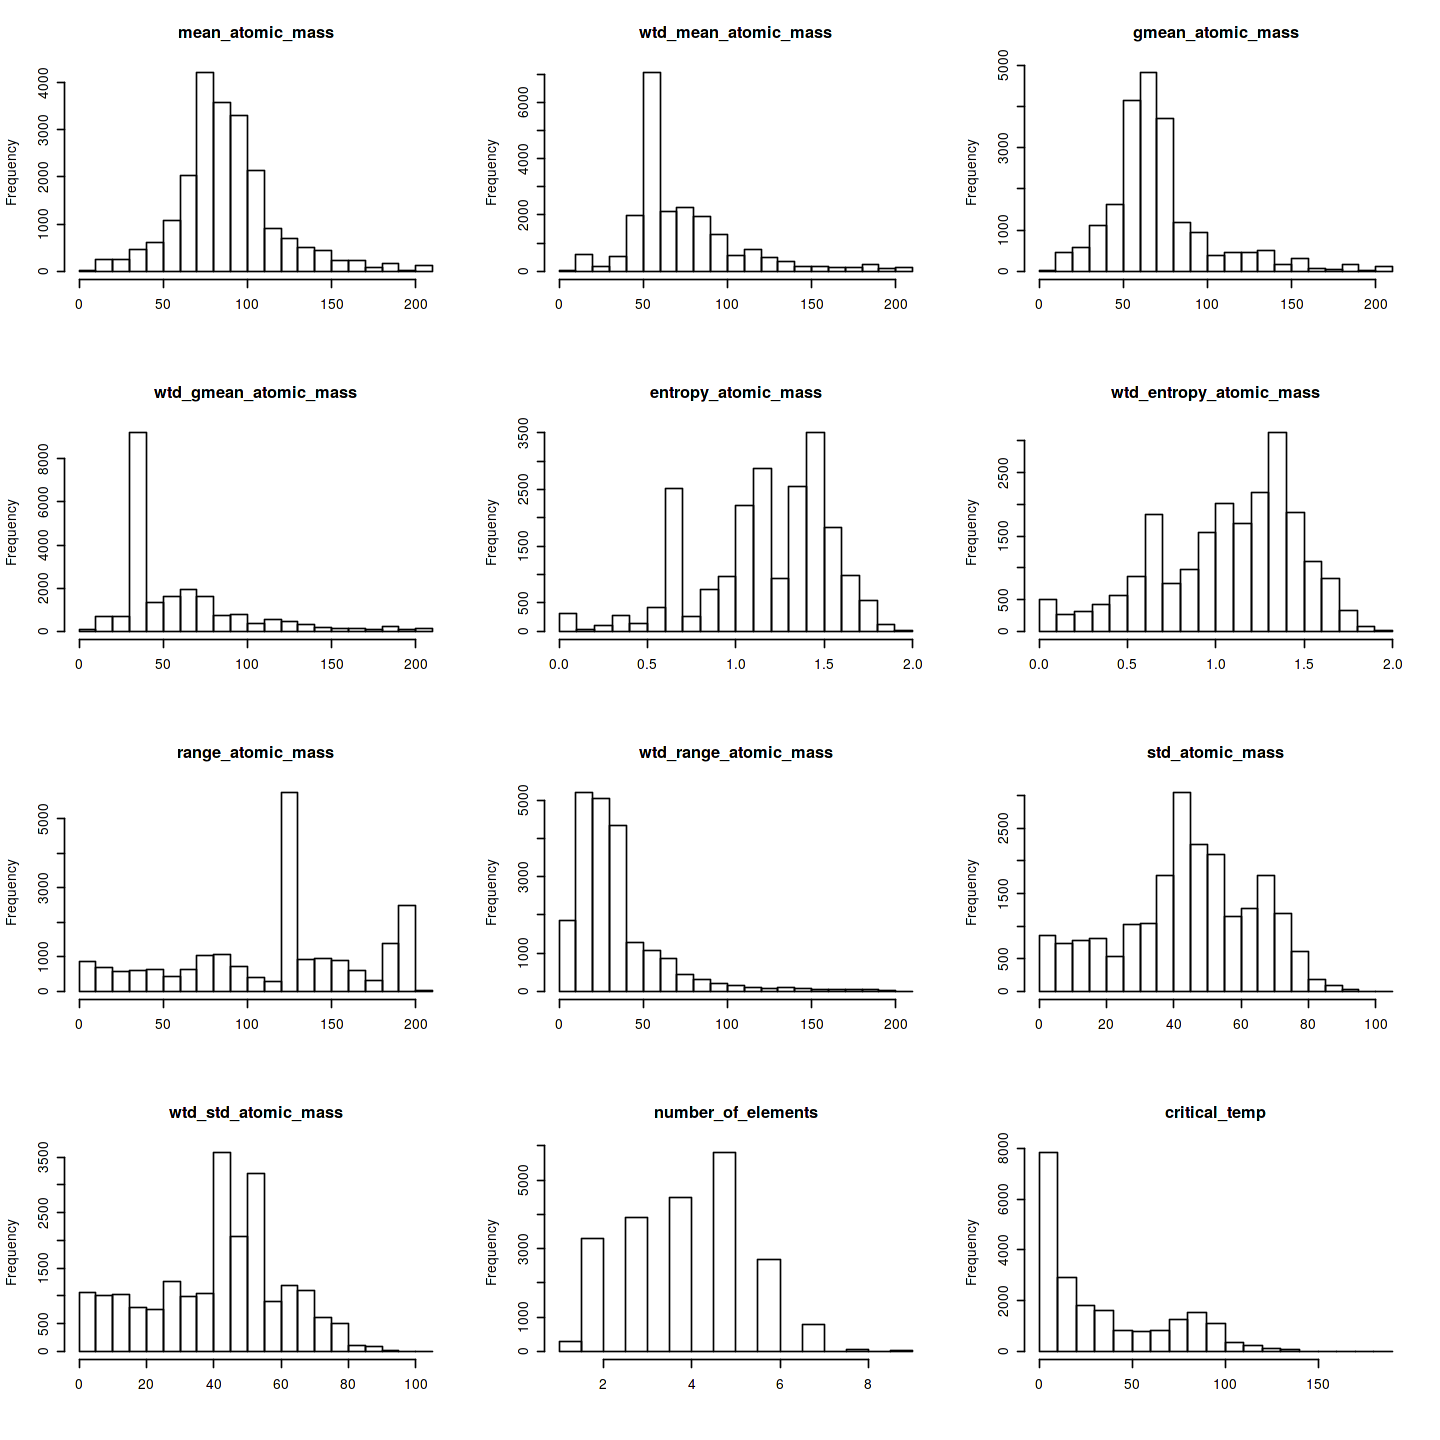

In [2]:
# Plot a histogram of each variable related with Atomic mass.
# Additionally, number of elements and critical temperature.
options(repr.plot.width=12, repr.plot.height=12)
par(mfrow = c(4,3))

for (i in 2:11){
    hist(data[,i], xlab = NULL, main= colnames(data)[i])
}

hist(data[,1], xlab = NULL, main= colnames(data)[1])
hist(data[,82], xlab = NULL, main= colnames(data)[82])


- Mean atomic mass exhibits a distribution that is closed to a normal distribution. Mean is around 80.
<br><br>
- Weighted mean atomic mass exhibits a distribution that has a positive skew with a mod around 60.
<br><br>
- Geometric mean atomic mass is right skewed and majority of the values are between 55-75. 
<br><br>
- Weighted geometric mean is highly right skewed. Vast majority of the substances has 40.
 <br><br>
- Entropy of atomic mass has several peak points. This shows parallelism to number of elements graph which is very significant in entropy calculation.
<br><br>
- Range of atomic mass has a peak at 125.
<br><br>
- Weighted range of atomic mass is highly right skewed and has a peak around 30. That is significantly different from range of atomic mass distribution which has peak around 130. This suggests that high atomic mass elements more likely to have less weight in the substance's formula because when they are multiplied with their weight in the compound, they got significantly smaller and narrowed down the difference between elements of the material. The logic also applies other way around for the elements with a small atomic mass.


__Skewed distributions;__
- wtd_gmean_atomic_mass
- wtd_range_atomic_mass

### Critical Tempterature

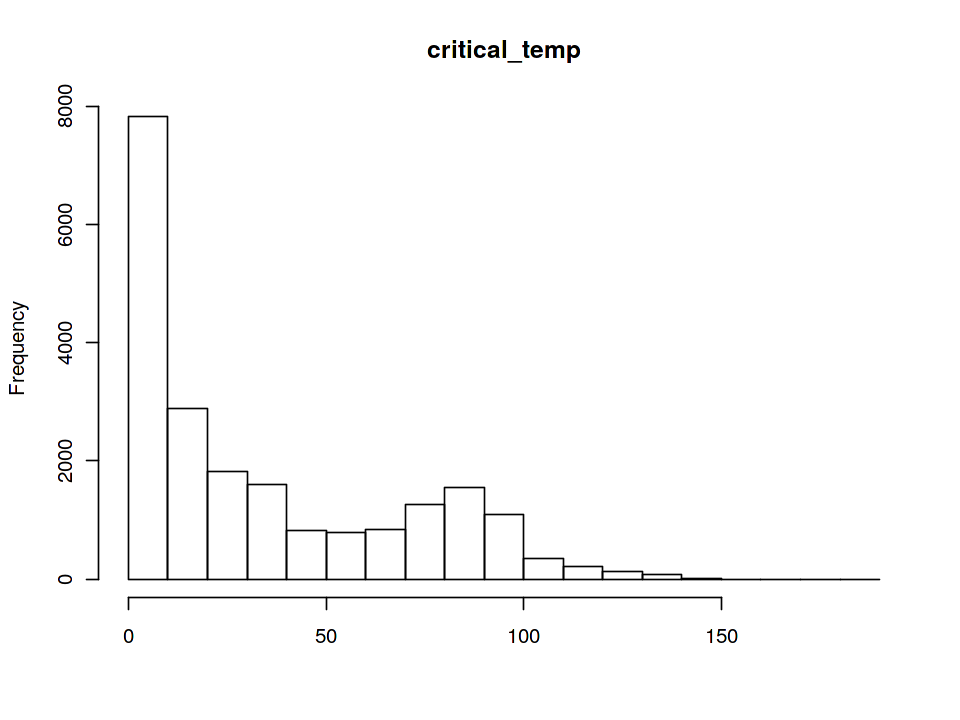

In [3]:
# Plot a boxplot of each variable related with critical temperature.
# Additionally, number of elements and critical temperature.
options(repr.plot.width=8, repr.plot.height=6)
hist(data[,82], xlab = NULL, main= colnames(data)[82])


- Critical temperature which will be the response variable of our analysis is also right skewed and most of the substances have critical temperature value between 0 and 10.
<br><br>
- There is one outlier which is also spotted in the previous boxplots with 200 critical temperature value.
<br><br>
- To look whether it has a log-normal distribution, log transformation will be apllied to critical temperature variable in the next step

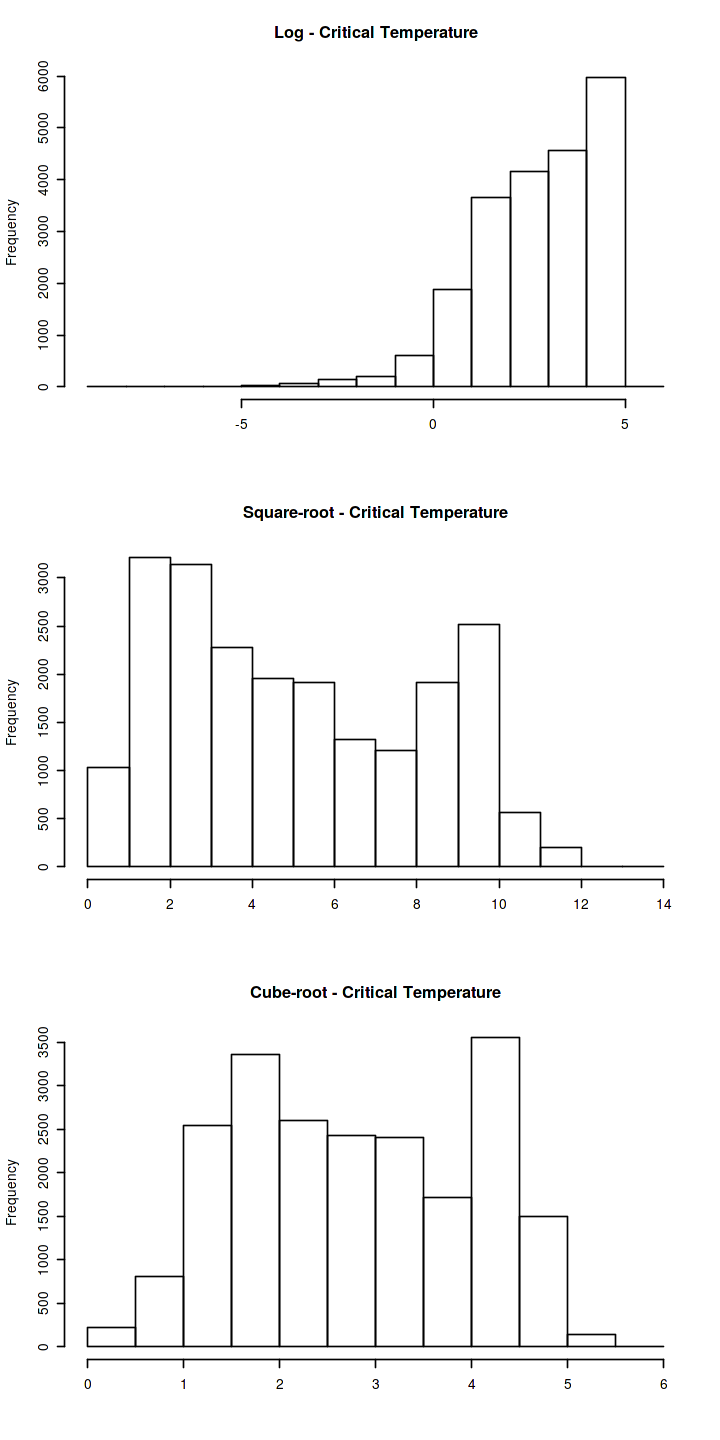

In [4]:
# Draw Histograms for different transformations
options(repr.plot.width=6, repr.plot.height=12)
par(mfrow=c(3,1))
hist(log(data[,82]), xlab = NULL, main= 'Log - Critical Temperature')
hist(sqrt((data[,82])), xlab = NULL, main= 'Square-root - Critical Temperature')
hist(((data[,82]))^(1/3), xlab = NULL, main= 'Cube-root - Critical Temperature')

- Cube Root transformation made the the response variable more normally distributed compared to other 2 transformation and the orginal version though not much different than the square-root transformation.

<a id="section2.3"></a>
## 2.3 Summary of Findings from Distributions
**Not all the distribution graphs are not included in this notebook to avoid mess but all findings are presented here.**

- Weighted mean and weighted geometric mean distributions are likely to follow similar patterns.
<br><br>
- Mean and geometric mean distributions are likely to follows similar patterns as well
<br><br>
- Depending on the feature, Entropy and weighted entropy values are also likely to follow similar patterns with each other.
<br><br>
- Range and standard deviation distributions are mostly follows same pattern due to their nature. Both are measure of spread in the data.
<br><br>
- Weighted range and weighted standard deviation distributions sometimes showed parallelism with each other.
<br><br>
-  Many distributions have right skew, some with outliers. Suggesting that log transformations of these predictors potentially perform better in linear regression model.
<br><br>
- Mean_Density, gmean_Density, wtd_mean_Density, wtd_gmean_Density ranges from 1 to 22600 which can cause heteroscedasticity of residuals in linear model.

<a id="section2.4"></a>
## 2.4 Correlation Analysis Between Predictors

Due to the high number of columns, dataframe will be divided according to features and the correlation between different features will be investigated one by one (except for number of elements), instead of looking all columns together. Aim is to understand correlation between features in stead of columns. Functions used to derive different columns (i.e. entropy, weighted mean etc.) can easily create high correlation values. Therefore, this effect should be seperated when conculuding our understanding of the correlations between features.
<br><br>
Additionally, correlation values higher than 0.5 or lower than -0.5 will be evaluated as significant. Correlation values will be filtered first and then they will be evaluated for each pair.

### Number of Elements - Other predictors

In [5]:
# Choose pairs with a absolute correlation value higher than 0.5, order then print
df = cor(no_elements,data[,-82])
df = melt(df)
colnames(df)[3] ="Correlation"
df[,1] = "number_of_elements"
df = df[(df$Correlation > 0.5 | df$Correlation < -0.5),]

# Order rows according to correlation value
df = arrange(df, -Correlation)

# Add index column
df["index"] = 0

# Reorder columns
df = df[,c(4,1,2,3)]

# Assign values of index column
df["index"] = 1: length(df$Correlation)

cat("Number of columns have absolute correlation value higher than 0.5: ",length(df$Correlation))
cat("\nHighest positive correlation value is: ", df$Correlation[1])
cat("\nHighest negative correlation value is: ", df$Correlation[length(df$Correlation)])

Number of columns have absolute correlation value higher than 0.5:  39
Highest positive correlation value is:  1
Highest negative correlation value is:  -0.6592677

According to above results;
- Entropy and weighted entropy measures of all features are strongly correlated with number of elements. This is very intuitive because entropy is a measure of diversity in the data. Therefore, increased number of elements ends up with an increase in diversity and consequently, an increase in entropy.
<br><br>
- Range and standard deviation are measure of variability in the data so these are positively correlated with number of elements due to same reason.
<br><br>
- Central tendency measures of valance and density shows negative correlation between number of elements. 
<br><br>
__First  2 findings suggest that variability and diversity measures of all features are strongly correlated with number of elements. Therefore, in the upcoming steps these measures will not be included in the comparison of features. Instead, central tendency measures such as mean, weighted mean, geometric mean and weighted geometric mean values of features will be used to examine correlations.__
<br><br>
__Last finding suggest that there is a correlation between number of elements - valance and number of elements - density.__

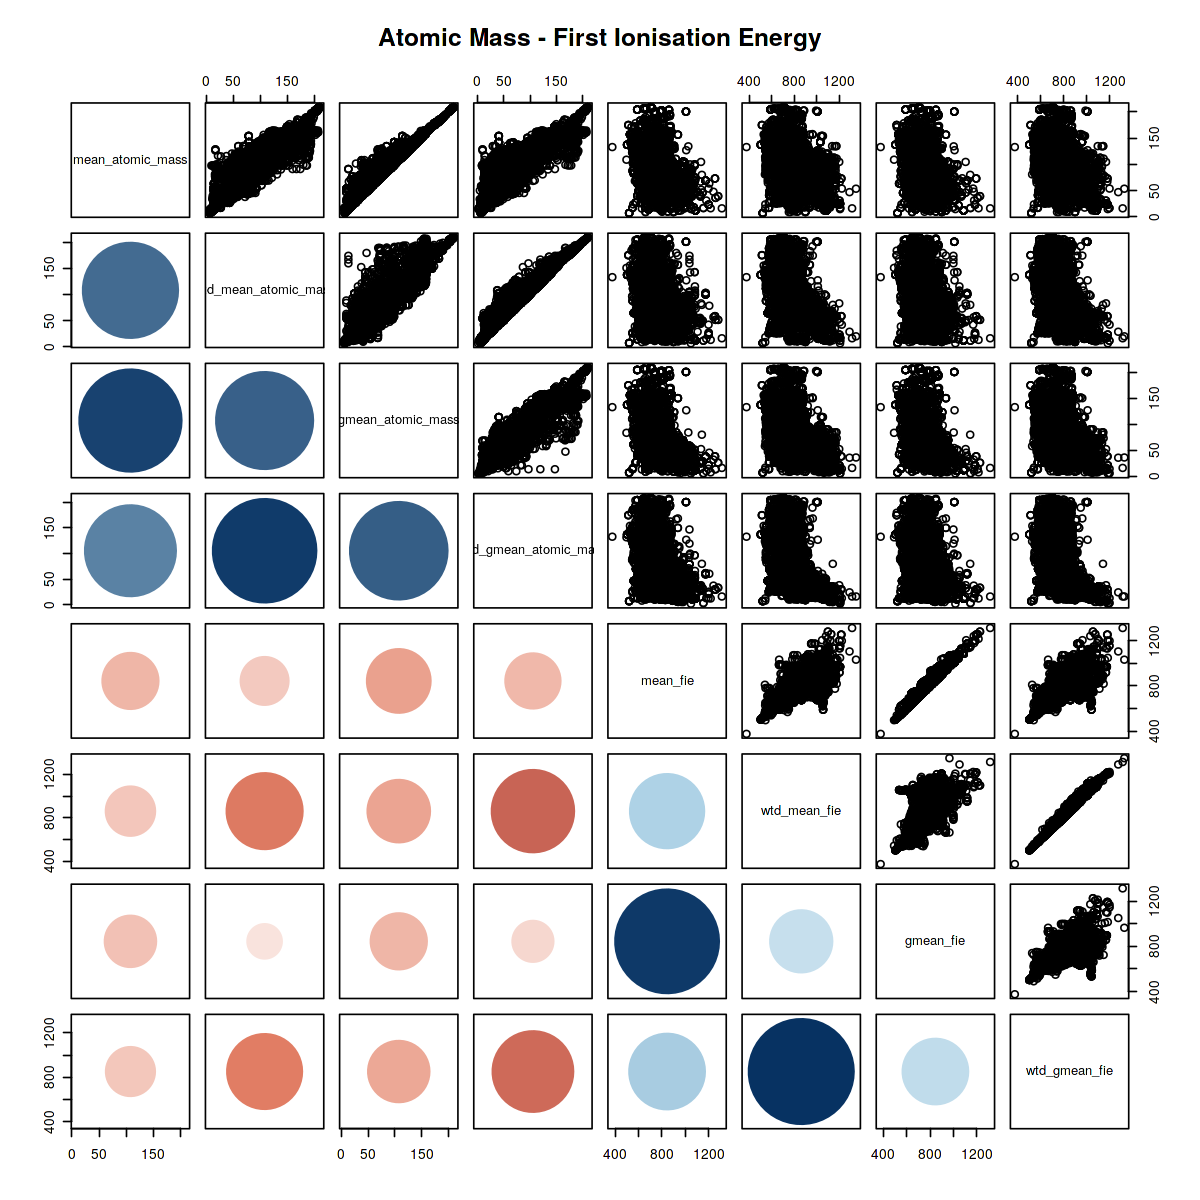

In [6]:
# Define colors
colorRange <- c('#69091e', '#e37f65', 'white', '#aed2e6', '#042f60')
## colorRamp() returns a function which takes as an argument a number
## on [0,1] and returns a color in the gradient in colorRange
myColorRampFunc <- colorRamp(colorRange)

# Function to modify lower panel of pairs
panel.cor <- function(w, z, ...) {
    correlation <- cor(w, z)

    ## because the func needs [0,1] and cor gives [-1,1], we need to shift and scale it
    col <- rgb(myColorRampFunc((1 + correlation) / 2 ) / 255 )

    ## square it to avoid visual bias due to "area vs diameter"
    radius <- sqrt(abs(correlation))
    radians <- seq(0, 2*pi, len = 50) # 50 is arbitrary
    x <- radius * cos(radians)
    y <- radius * sin(radians)
    ## make them full loops
    x <- c(x, tail(x,n=1))
    y <- c(y, tail(y,n=1))

    ## Divide the view into parts
    par(new=TRUE)
    plot(0, type='n', xlim=c(-1,1), ylim=c(-1,1), axes=FALSE, asp=1)
    polygon(x, y, border=col, col=col)
}

options(repr.plot.width=10, repr.plot.height=10)
pairs(c(atomic_mass[,1:4],fie[,1:4]),
      lower.panel=panel.cor, main="Atomic Mass - First Ionisation Energy")

<a id="section2.5"></a>
## 2.5 Summarising Results of Correlation between Predictors
**Not all the correlation graphs are included in this notebook to avoid being messy but all results are presented here.**

__Strongest correlation lying between 0.7 and 0.9 are observed between;__
- Atomic mass - Density
- Atomic mass - Atomic radius
- Atomic radius - First Ionisation Energy
- Atomic radius - Density
- Density - Valance

__Other significant correlations can be noted as follows;__
- Atomic mass -  First ionisation energy
- Atomic mass - Valance
- First Ionisation energy - Density
- First Ionisation energy - Valance
- Atomic radius - Valance
- Denisty - Thermal conductivity
- Fusion heat - Thermal conductivity
- Fusion heat - Valance
<br><br>
__Correlation between central tendency measures;__
- Density and valance has a strong positive correlation and it looks linear.
- Atomic radius and electron affinity has negative linear correlation.
- Fie and atomic radius have a strong negative correlation. Possibly linear.
- Density and atomic mass have strong positive linear correlation. This make sense if we consider the chemical formula for density which is mass / volume.

- __Central tendency measures likely to exhebit same correlations with the same features.__
<br><br>
__Correlation between variability measures;__
- Except for thermal conductivity, almost all of the features exhibits a strong or significant positive correlation with each others variability measures. Number of elements can be the reason behind this correlations due to derivation of measures.

- Number of elements are highly correlated with almost all of the variabilty measures(std, range and entropy) of all the properties.

- Correlation matrixs between variability measures such as entropy, standard deviation and range, follow similar patterns. Only difference is strength of correlations though these matrixes mostly look like sclaed version of each other.  This suggest that different variability measures reveal the same relationships between features with different levels of strength.

- Additionally, It is observed that correlations between variability measures are significantly strong. This situation may lead a collinearity problem of predictors in linear regression model though most of the correlations are due to transformations of the variables (Structral collinearity). Hence, this should not effect the predictive performans of the models.
<br><br>
According to above results, one can claim that there is complex correlation network between predictors. This is one thing that challanges linear regression model's initial assumption. Linear regression models assume that all the predictors are independent from each other whereas in our dataset there are unignorable correlations between predictors. This situation makes it hard to guess best predictors only by looking at their relationship with response because eventhough one varaible has a strong correlation with response, it doesn't necessarily mean that this variable should be included in our model. There can be other predictor combinations that may give a better prediction performance.

<a id="section2.6"></a>
# 2.6 Correlation Analysis Between Response and Predictors

In this stage of the analysis, similar approach will be used as used in investigation of correlations between predictors.

First correlation values will be determined between response variable and the predictor and then if a significant correlation is observed, further investigation will be conducted by plotting these two variables on a scatter plot. 
### Critical Temperature - Number of Elements

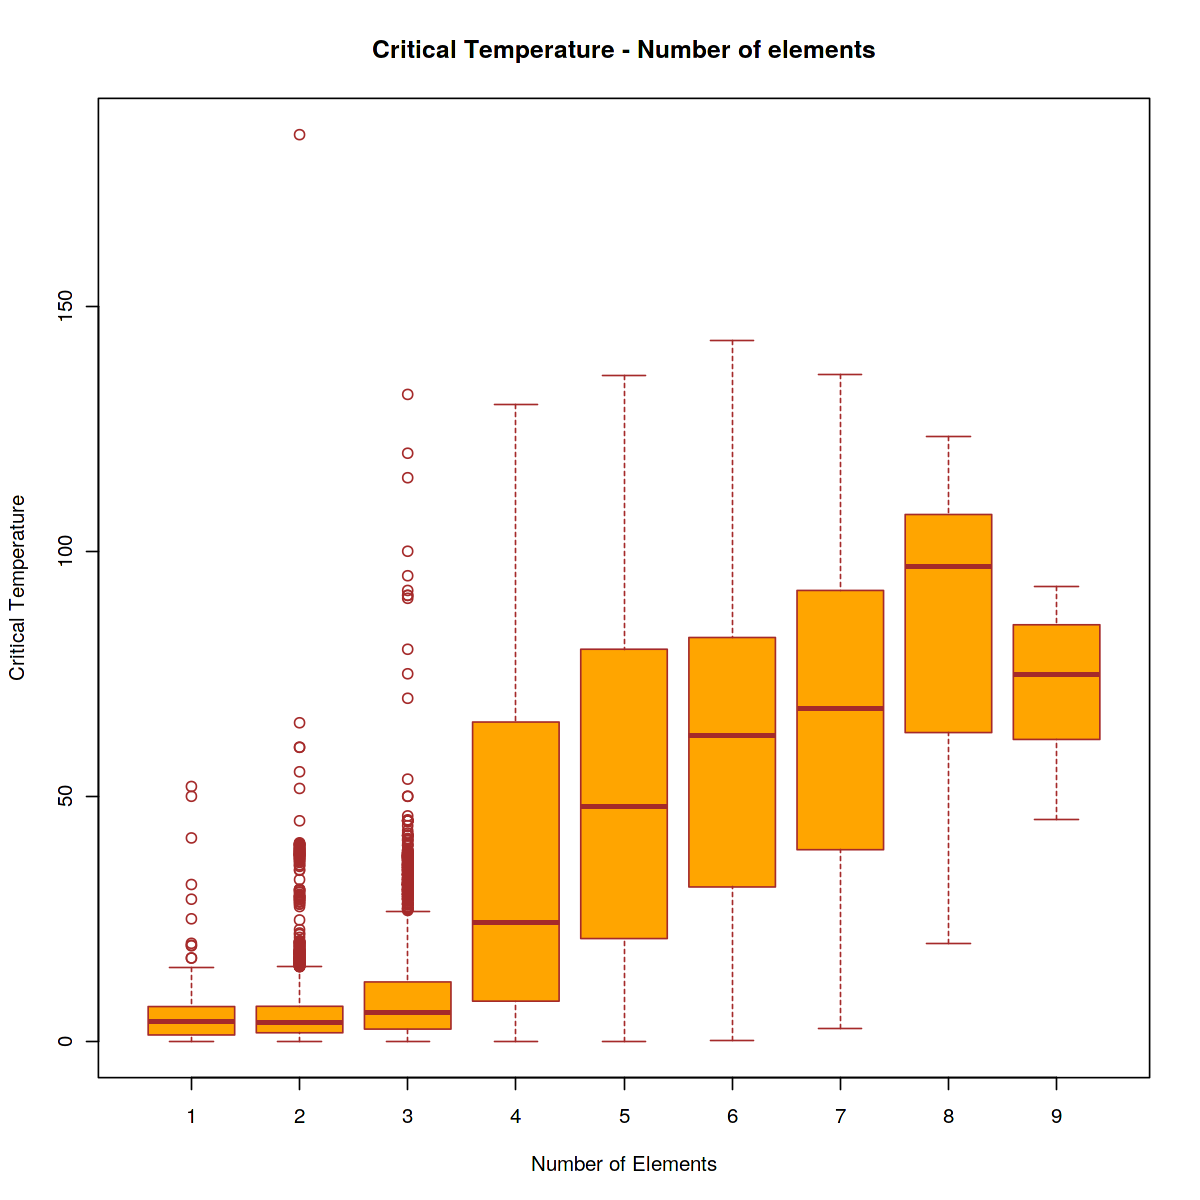

In [7]:
# Draw boxplot
boxplot(critical_temp~number_of_elements,data=data,
        main="Critical Temperature - Number of elements",
        xlab="Number of Elements", ylab="Critical Temperature",
        col="orange",border="brown")

According to above graph and correlatio value;
- Substances that have 3 or less number of elements tends to have similar critical temperature value.
- Substances that have 4 or more number of elements tends to follow a linearly increasing critical temperature value path.
- Number of elements can be included in linear regression as factor variable though according to graph using it like a continous variable would not create much problem as well.
- 0.6 correlation value represents a significant relationship and should be included in the model though, number of elements is also highly correlated with entropy measures of other features creating a risk of collinearity among predictors.

### Critical Temperature - Density

index Var1 Var2              Correlation
1 1     1    wtd_gmean_Density -0.5400456 
2 2     1    gmean_Density     -0.5416844

Number of columns have absolute correlation value higher than 0.5:  2
Highest negative correlation value is:  -0.5416844

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'



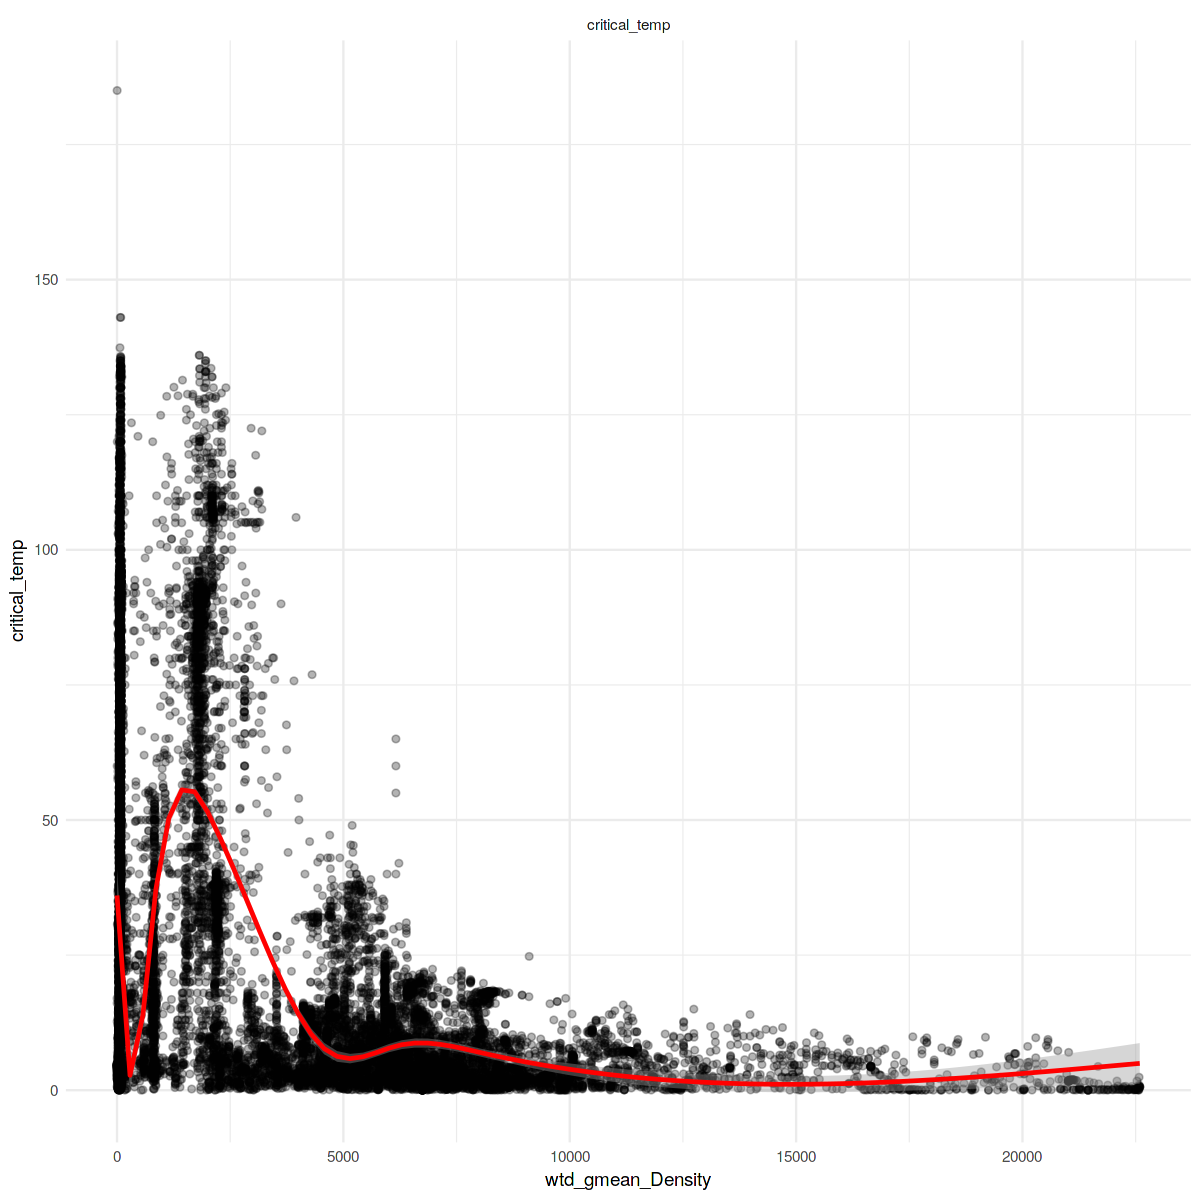

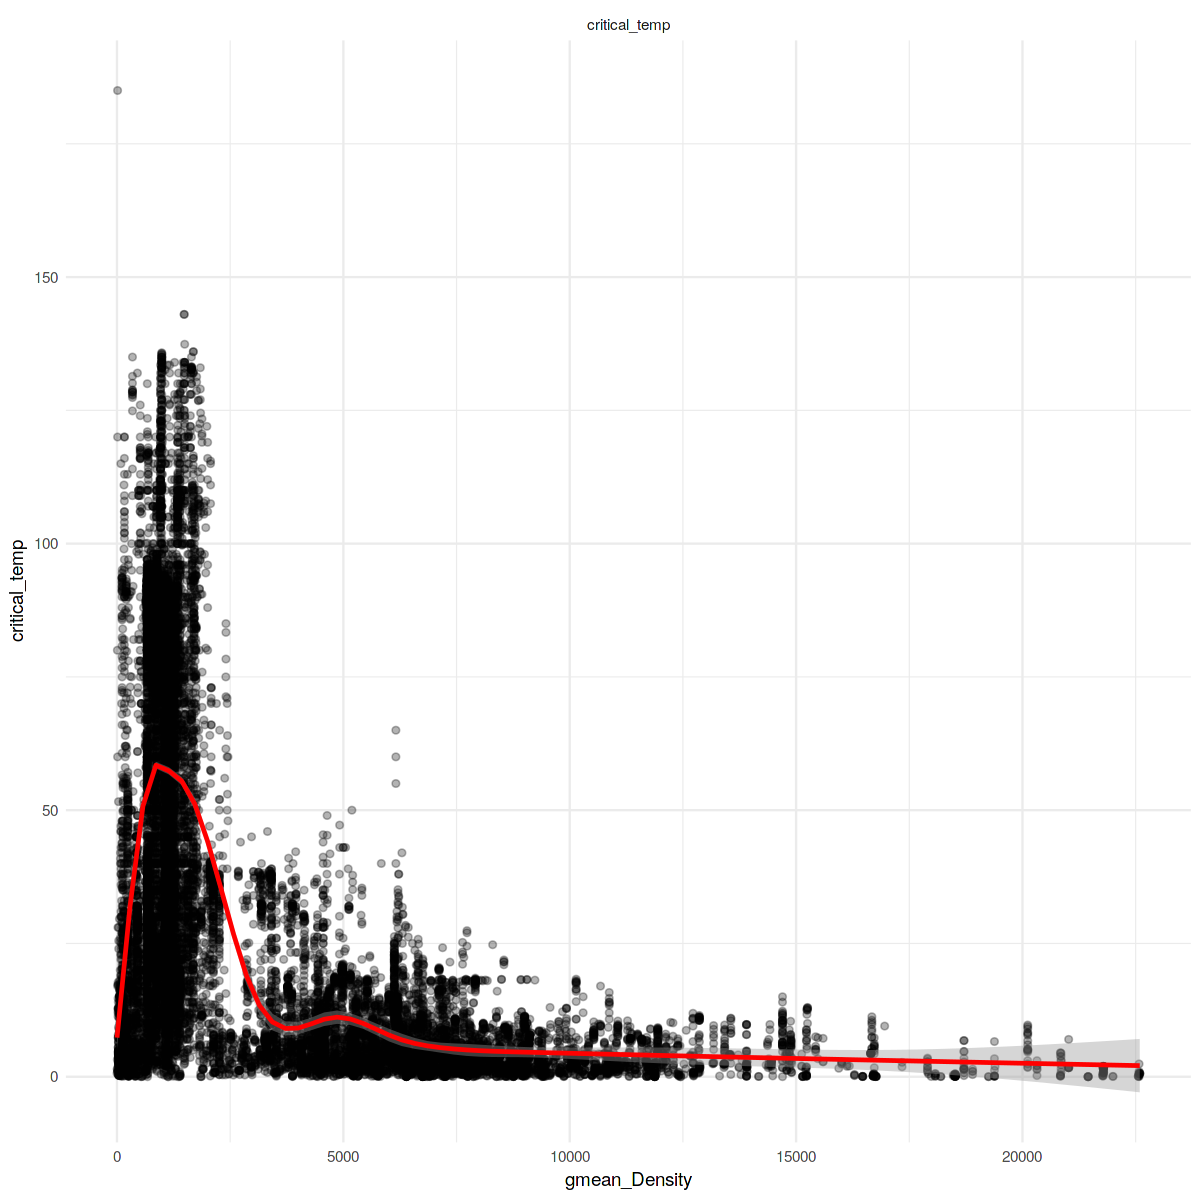

In [8]:
# Choose pairs with a absolute correlation value higher than 0.5, order then print
df = cor(critical_temp,density) # First 4 columns are measure of central tendency.
df = melt(df)
colnames(df)[3] ="Correlation"
df = df[(df$Correlation > 0.5 | df$Correlation < -0.5),]

# Order rows according to correlation value
df = arrange(df, -Correlation)

# Add index column
df["index"] = 0

# Reorder columns
df = df[,c(4,1,2,3)]

# Assign values of index column
df["index"] = 1: length(df$Correlation)

df
cat("Number of columns have absolute correlation value higher than 0.5: "
    ,length(df$Correlation))

if(df$Correlation[1]>0)
{cat("\nHighest positive correlation value is: ", df$Correlation[1])}

if(df$Correlation[length(df$Correlation)]<0)
{cat("\nHighest negative correlation value is: ", df$Correlation[length(df$Correlation)])}

# Draw Scatter plots with a regresion line for highly correlated variables with response
for (variable in df[,"Var2"]){
    p = ggplot(data, aes_string(x = variable, y = "critical_temp")) +
    geom_point(alpha=0.3) + 
    geom_smooth(method="auto",se=TRUE, fullrange=FALSE,level=0.95, color='red')+
    facet_wrap( ~  "critical_temp", ncol=2) + theme_minimal() 
    print(p)
}

<a id="section2.7"></a>
# 2.7 Important Findings
According above to plots;
- Most of the strong correlations between response and predictors are not linear suggesting to use transformation of the predictors or response.

According to above correlation calculations;

__Atomic Mass - Critical Temperature :__ Strongest correlation value is 0.6 and there are 2 features of atomic mass that exhibits stronger correlation than 0.5

__First Ionisation Energy - Critical Temperature :__ Strongest correlation value is 0.55 and there are 4 features of fie that exhibits stronger correlation than 0.5.

__Atomic Radius - Critical Temperature :__ Strongest correlation value is 0.6 and there are 5 features of atomic radius that exhibits stronger correlation than 0.5

__Density - Critical Temperature :__ Strongest correlation value is 0.55 and there are 2 features of Density that exhibits stronger correlation than 0.5.

__Electron Affinity - Critical Temperature :__  No correlation stronger than 0.5 is observed.

__Fusion Heat- Critical Temperature :__ HighStrongestest correlation value is 0.55 and there are 2 features of fusion heat that exhibits stronger correlation than 0.5

__Thermal Conductivity - Critical Temperature :__ Strongest correlation value is 0.7 and there are 3 features of thermal conductivity that exhibits stronger correlation than 0.5.

__Valence - Critical Temperature :__ Strongest correlation value is 0.6 and there are 6 features of Valence that exhibits stronger correlation than 0.5.

By considering above results, one can say that ranking of top 4 correlations between critical temperature and other features are as follows;
1. Thermal Conductivity
2. Valence
3. Atomic Radius
4. Atomic Mass

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'



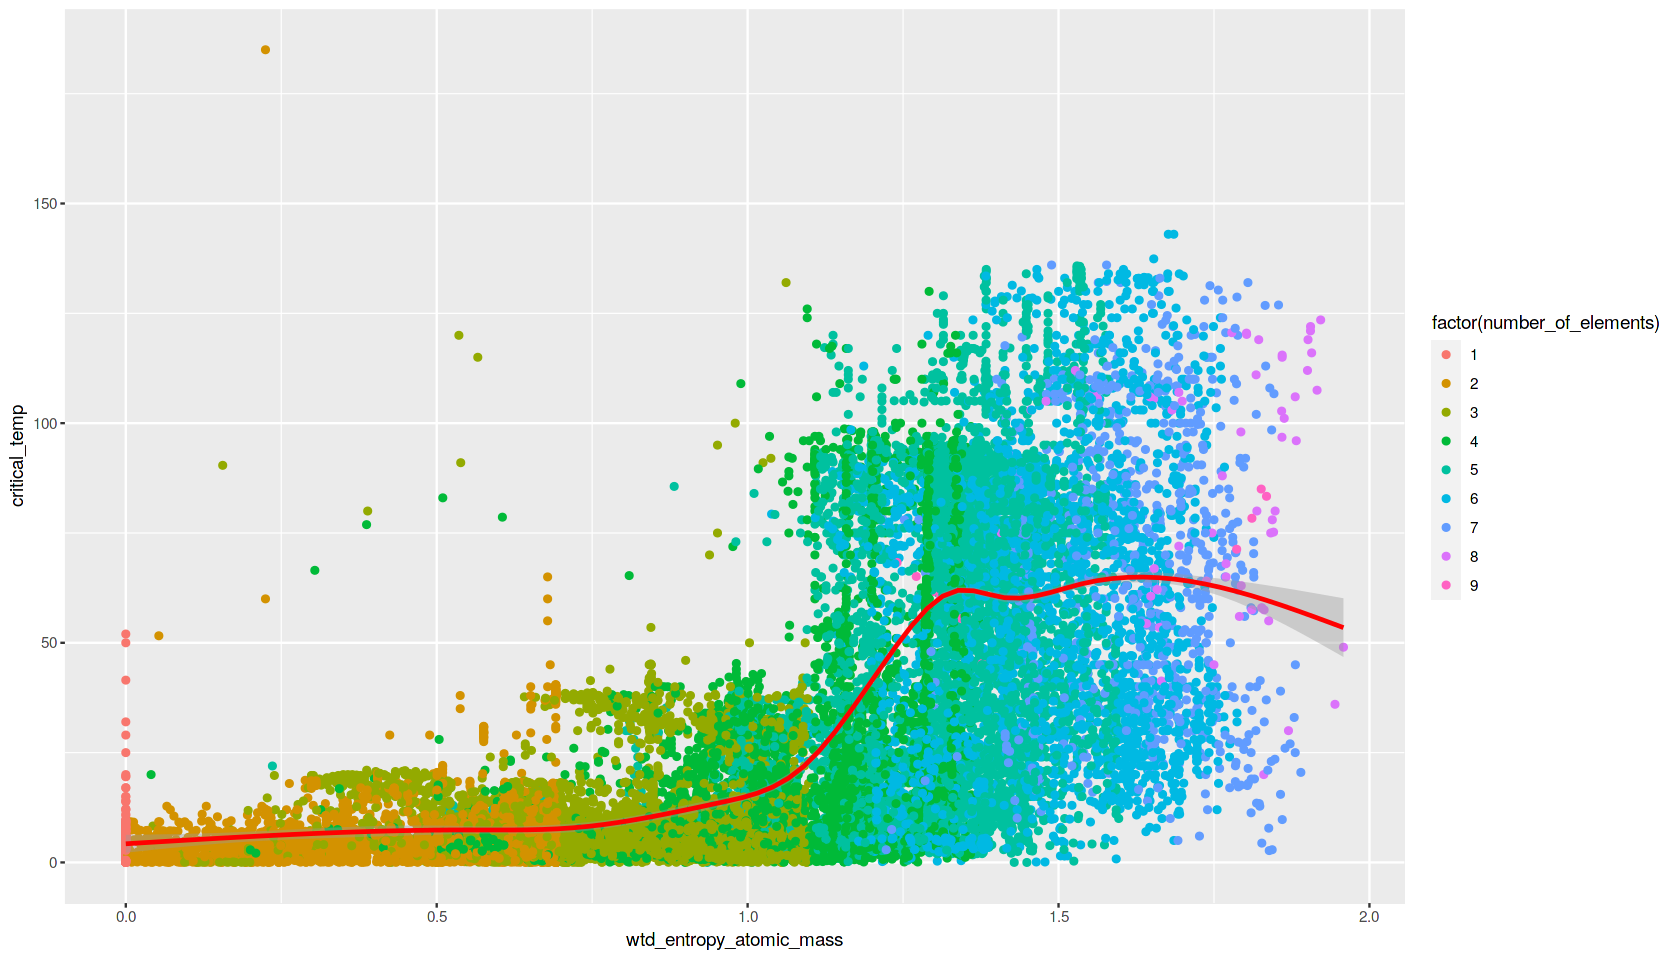

In [9]:
# Draw scatter plot and add regresion line
options(repr.plot.width=14, repr.plot.height=8)
ggplot(data, aes(x=wtd_entropy_atomic_mass, y=critical_temp)) + 
geom_point(aes(color=factor(number_of_elements))) +
geom_smooth(method="auto",se=TRUE, fullrange=FALSE,level=0.95, color='red')

Slope of regression line is different for different number of elements suggesting that there is a collinearity between 2 predictors.
- __For high number of elements, one unit of increase in wtd_entropy_atomic_mass results in a higher increase in critical temperature compared to low number of elements.__

### According to above graph;
- __Number of elements <= 3 and number of elements > 3 , creates 2 groups that act differently than each other. Therefore, these 2 groups can be created and could be added to model as interactions with other predictors.__

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'



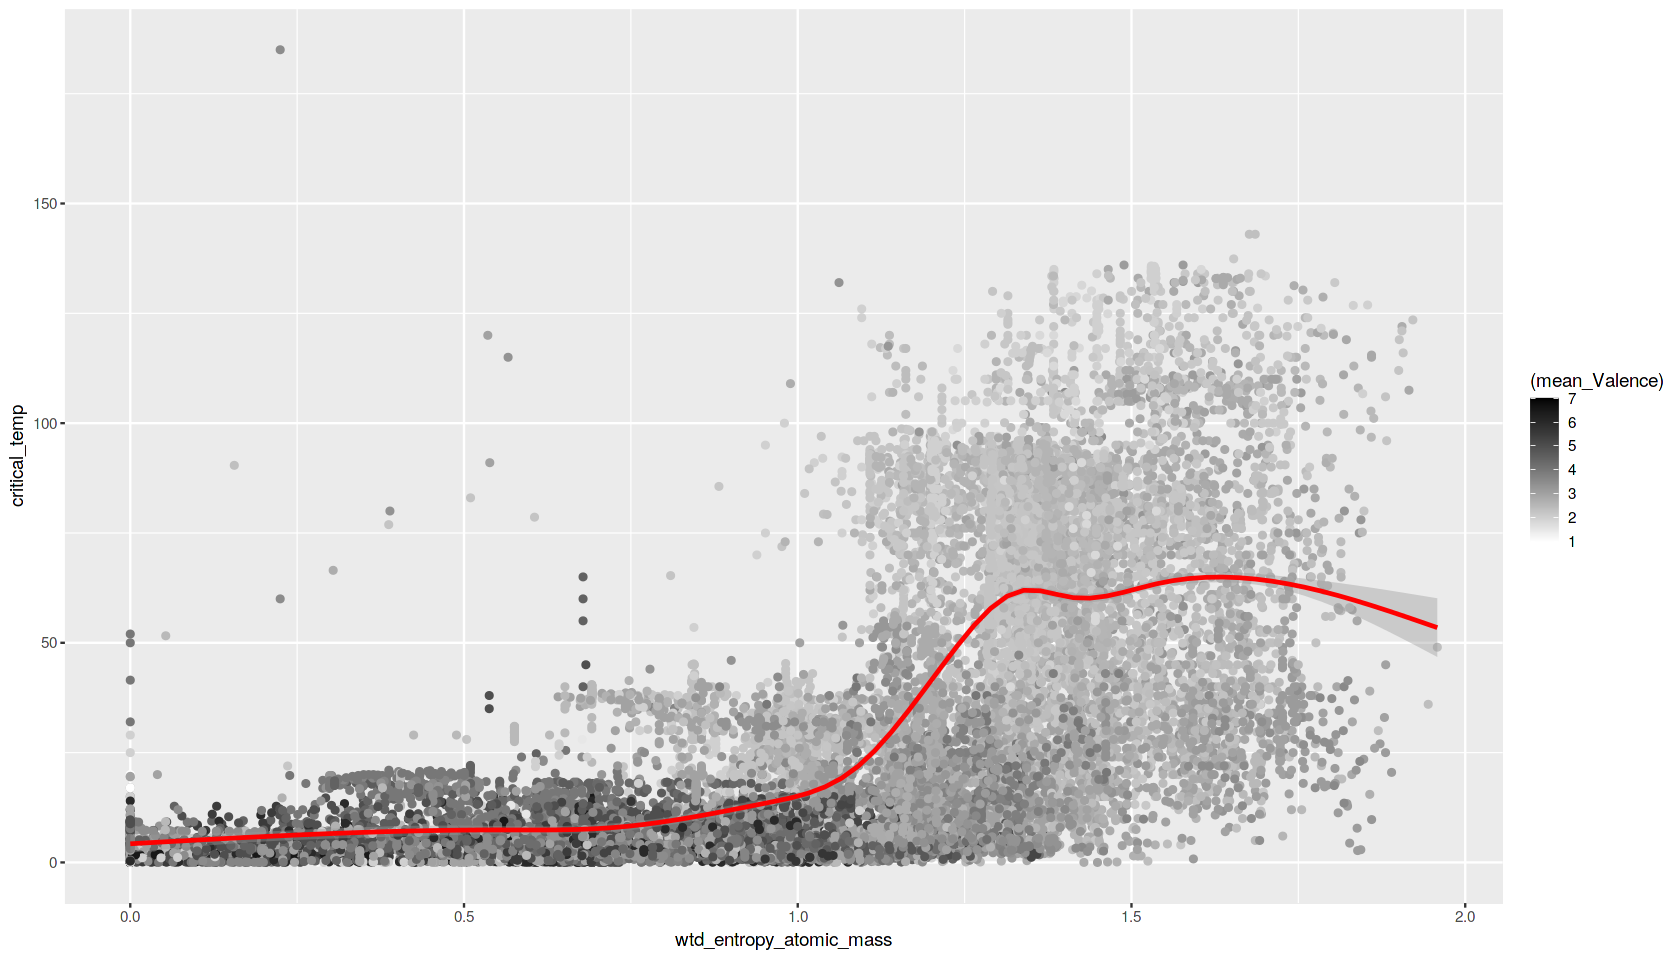

In [10]:
# Draw scatter plot and add regresion line
ggplot(data, aes(x=wtd_entropy_atomic_mass, y=critical_temp)) + 
geom_point(aes(colour=(mean_Valence))) +
geom_smooth(method="auto",se=TRUE, fullrange=FALSE,level=0.95, color='red') +
scale_colour_gradient(low = "white", high = "black")

According to above results for mean_Valence and number of elements;
- __Number of elements <= 3 and number of elements > 3 , creates 2 groups that act differently than each other. Therefore, these 2 groups can be created and could be added to model as interactions with other predictors to more accurately explain variability in response variable.__

- __mean_Valence <= 4 and mean_Valence > 5 , creates 2 groups that act differently than each other. Therefore, these 2 groups can be created and could be added to model as interactions with other predictors to more accurately explain variability in response variable.__

<a id="section3"></a>
# 3. Regression Model Development

- In this part all of the 81 predictors will be included in the initial set of predictors then using subset selection and parameter shrinkage methods, best possible models will be identified and compared.

- Stepwise parameter selection will be performed using AIC, BIC, adjusted R^2 and C_p measures.

- Best subset selection is too costly to perform due to high number of predictors. It would require to train and compare 2^81 models. Hence, only forward and backward selection approachs will be performed.

## Defining Performance Measures of Models
### Accuracy Function

**Name:** Model.Accuracy

**Input parameters:**
- predicted - a vector of predictions
- target - a vector containing the target values for the predictions 
- df - the degrees of freedom
- p - the number of parameters excluding the coefficient

**Return Value:**
A list containing:
- rsquared - the R-Squared value calculated from the predicted and target values
- rse - the residual standard error
- f.stat - the F-statistic

**Description:**
Calculate the TSS and RSS as:
- TSS: $\sum_{i=1}^n (y_i - \bar y)^2$
- RSS: $\sum_{i=1}^n (\hat y_i - y_i)^2$
Calculate the statistics according to the following formulae:
- R-Squared value: $R^2 = 1 - \frac{RSS}{TSS}$
- Residual standard error - $\sqrt{\frac{1}{df}RSS}$
- F-statistics - $\frac{(TSS - RSS)/p}{RSS / df}$

### RMSE Function

**Name:** RMSE

**Input parameters:**
- predicted - a vector of predictions
- target - a vector containing the target values for the predictions 

**Return Value:**
The RMSE value calculated from the predicted and target values

**Description:**
Calculate the RMSE value: 
$RMSE = \sqrt {\sum_{i=1}^n (\hat y_i - y_i)^2 / N}$

In [11]:
# Define function to calculate F statistics, R^2 and Residual standard error
Model.Accuracy <- function(predicted, target, df, p) {
    rss <- 0
    tss <- 0
    target.mean <- mean(target)
    for (i in 1:length(predicted)) {
        rss <- rss + (predicted[i]-target[i])^2
        tss <- tss + (target[i]-target.mean)^2
    }
    rsquared <- 1 - rss/tss
    rse <- sqrt(rss/df)
    f.stat <- ((tss-rss)/p) / (rss/df)
    return(list(rsquared=rsquared,rse=rse,f.stat=f.stat))
}

# Define function to calculate Root-Mean-Squared-Error
RMSE <- function(predicted, target) {
    se <- 0
    for (i in 1:length(predicted)) {
        se <- se + (predicted[i]-target[i])^2
    }
    return (sqrt(se/length(predicted)))
}

### Regression with all features

In [12]:
# Create a multiple linear regression model that includes all of 81 predictors
fit1 <- lm(critical_temp ~ . , data=train)

- **R-squared value indicates that model explain 74% of the variability in the response variable (i.e critical temperature) of the training data.** It is also important to note that there are 81 predictors in this model and probably most of them don't really contribute much to this R^2 value though the more predictor the higher R^2.

- Also, p-value and F-statistics of the model suggest to reject the null hypothesis that suggests the model explains nothing. **p-value < 2.2e-16 means if these model is explaining nothing, observing this good fit or better fits with the training data only occur once in 2.2e+16 samples.**

- According to summary above, some predictors' p values are not significant so probably they will be removed with the applied procedure in subset selection

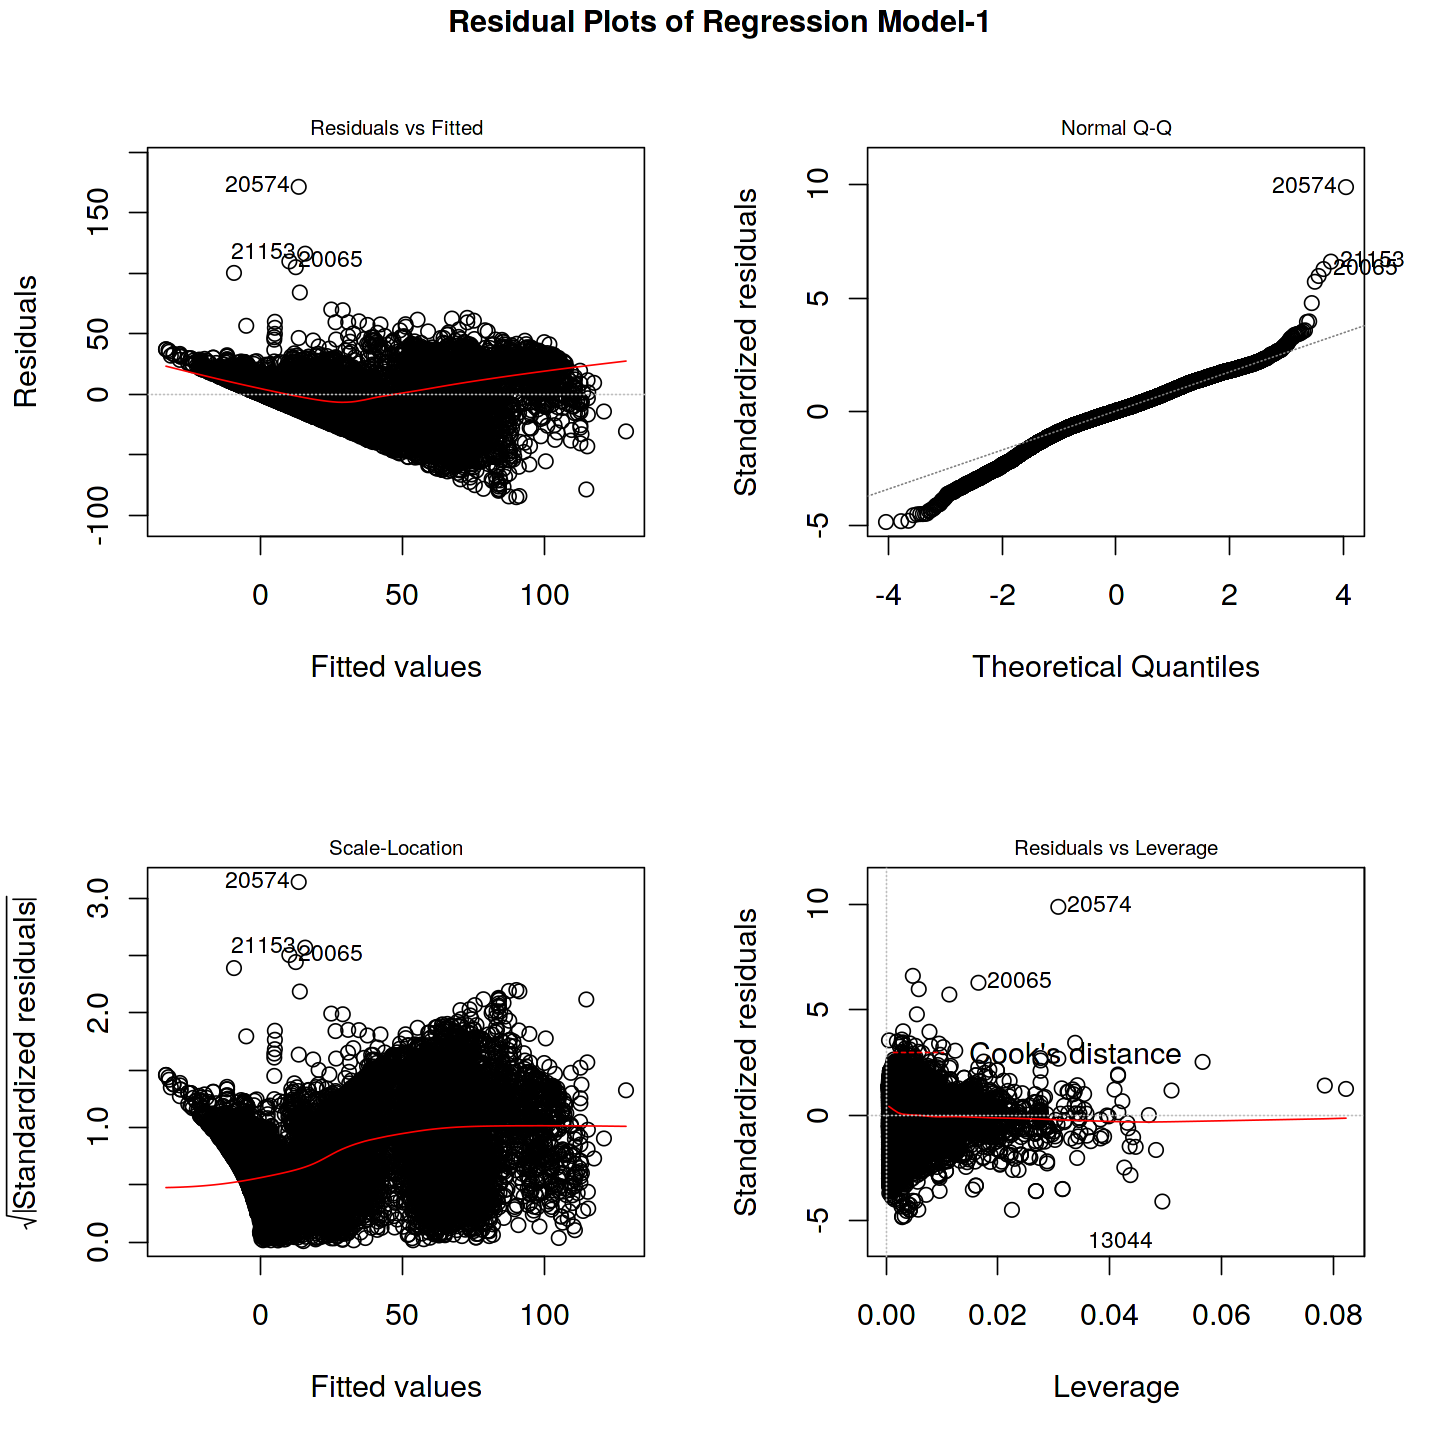

In [13]:
# Set the size of the plot
options(repr.plot.width=12, repr.plot.height=12)

# Check residuals using plot function
par(mfrow=c(2,2), cex = 1.5, cex.main = 1.5)
plot(fit1)
mtext("Residual Plots of Regression Model-1", line = -1, outer = TRUE, cex=1.5, font=2)

**Residual vs Fitted :** 
One important assumption of linear regression is that the error terms have a constant variance. The plot shows that residuals follow a "V" shape representing an increase in variance of the residuals with increasing fitted value. Moreover, from EDA, we know that critical temperature variable is skewed which can easily create that issue in the model. 

- **Hence, log and square root transformation of response variable (i.e. critical temperature) will be used in the next models to solve this issue.**
- Idea behind transformation of response variable in this case is, square root or log transformation will shrink more for the higher values of responses hence this spread distribution of residuals for higher predictions will be decresead. Consequently, heteroscedasticity will be reduced.

**Q - Q Plot :** Incidating that residuals are mostly normally distributed though, for the higher values of residuals they deviate significantly from dioganal line. This also supports that variance of residuals are not constant.

**Scale - Location :** This graph also suggests that increase fitted values ends up with an increase in standardised residuals so heteroscedasticity.

**Residuals vs Leverage :** No influential points, we cant even see cook's distance line.

### Log-Transformations of Response Variable

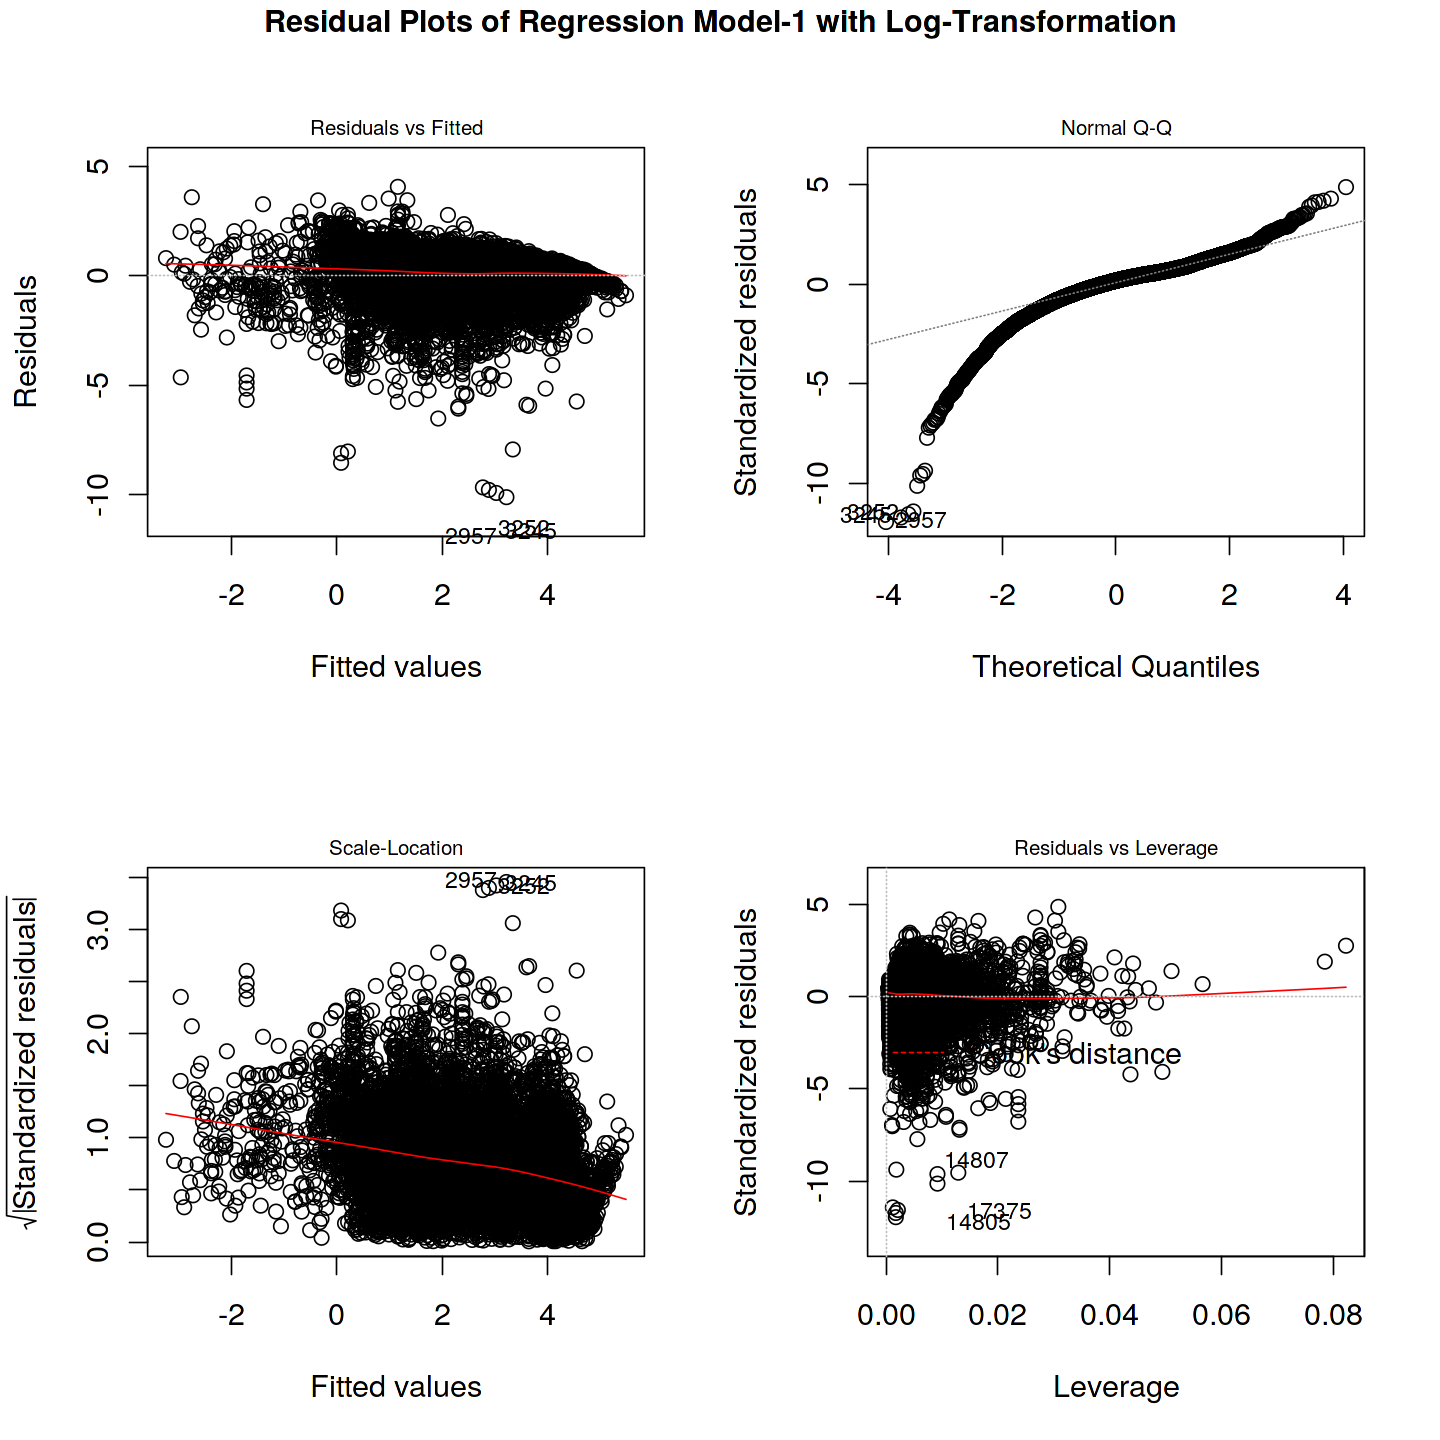

In [14]:
# Model with log transformaiton of response
fit2 = lm(log(critical_temp)~., data=train)

# Set the size of the plot
options(repr.plot.width=12, repr.plot.height=12)
# Check residuals using plot function
par(mfrow=c(2,2), cex = 1.5, cex.main = 1.5)
plot(fit2)
mtext("Residual Plots of Regression Model-1 with Log-Transformation", line = -1, outer = TRUE, cex=1.5, font=2)

In [15]:
# Calculate model accuracy measures for fit2
Model.Accuracy(exp(fit2$fitted.values), train[,82], df = 19048, p= 89)

$rsquared
        1 
0.7099467 

$rse
       1 
18.50713 

$f.stat
       1 
523.8503

According to above results;
- fit2 has 3% lower R^2 value and also, in terms of RSE and F-statistics first model performs better.

- Although, fit2 slightly decreased the variability of variance of residuals though residuals still don't have a constant variance. This time variance change due to increased range of negative residuals

- Also, Q-Q plot show that fit1's residuals are more normally distributed compared to fit2.

### Root-Transformations of Response Variable

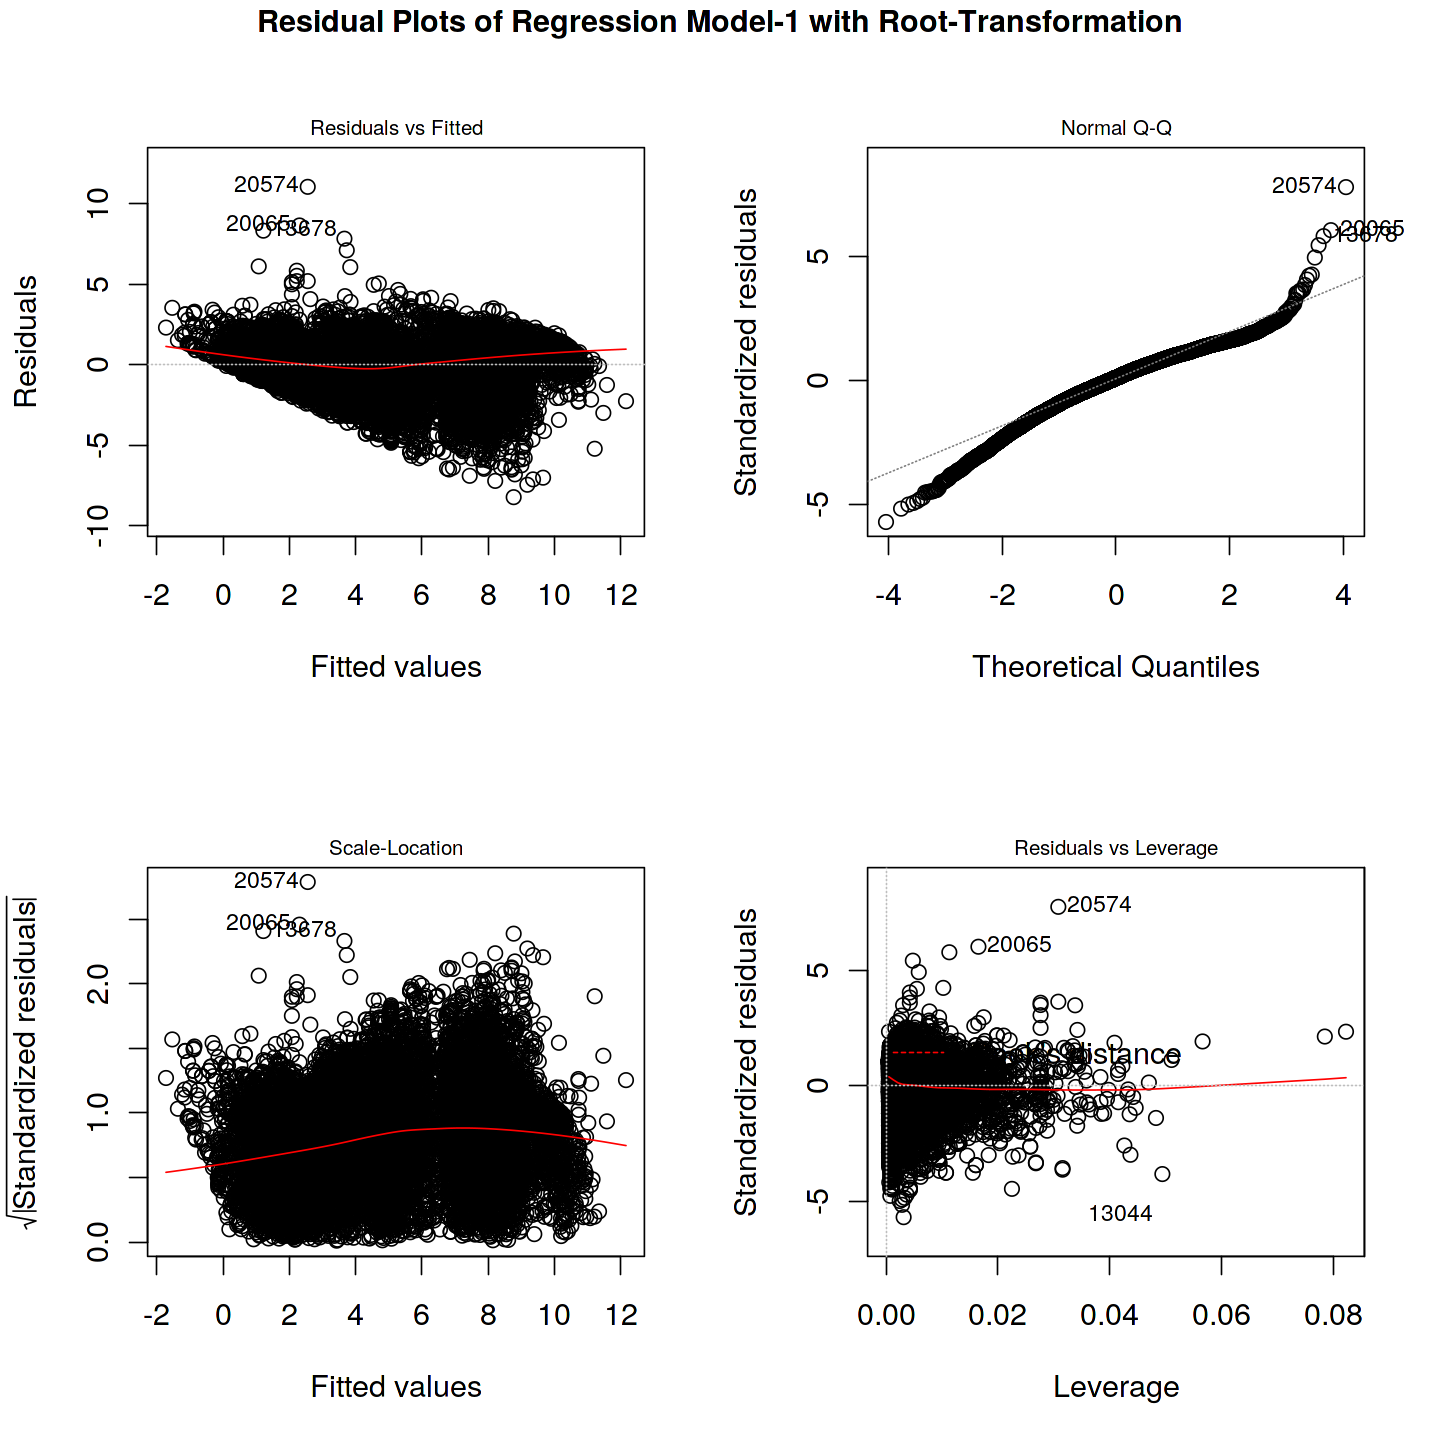

In [16]:
# Model with square-root transofrmation of response variable
fit3 = lm(sqrt(critical_temp)~., data=train)

# Set the size of the plot
options(repr.plot.width=12, repr.plot.height=12)
# Check residuals using plot function
par(mfrow=c(2,2), cex = 1.5, cex.main = 1.5)
plot(fit3)
mtext("Residual Plots of Regression Model-1 with Root-Transformation", line = -1, outer = TRUE, cex=1.5, font=2)

In [17]:
# Calculate model accuracy measures for fit3
Model.Accuracy((fit3$fitted.values)^2, train[,82], df = 19048, p = 89)

$rsquared
        1 
0.7564596 

$rse
       1 
16.95843 

$f.stat
       1 
664.7741

According to above results;
- fit3 improved R^2 value compared to fit1 and fit2 by 2% and 5% respectively. Also, in terms of RSE and F-statistics fit3 outperforms other 2 models.

- fit3 doesn't reduced much of the variability of variance of residuals though Scale-location graph still looks better than fit2.

- In terms of Q-Q plot, fit1 and fit3 looks similar and they provide much normally distributed residuals compared to fit2.

__All in all, square root transformation of the response variable seems like the best option. We also know from EDA that square root transformation of response variable is less skewed than log and plain versions of it.__
<a id="section3.1"></a>
## 3.1 Stepwise Feature Selection with Cp, adj_R^2 and BIC

In [18]:
# Perform forward selection using Cp, adj_R^2, BIC.
regfit.fwd <- regsubsets(sqrt(critical_temp) ~ ., 
                         data = train, method = "forward", nvmax = 81)
reg.summary.fwd <- summary(regfit.fwd)

Number of predictors for Minimum C_p: 77
Number of predictors for Minimum BIC: 66
Number of predictors for Maximum adj_R2: 77

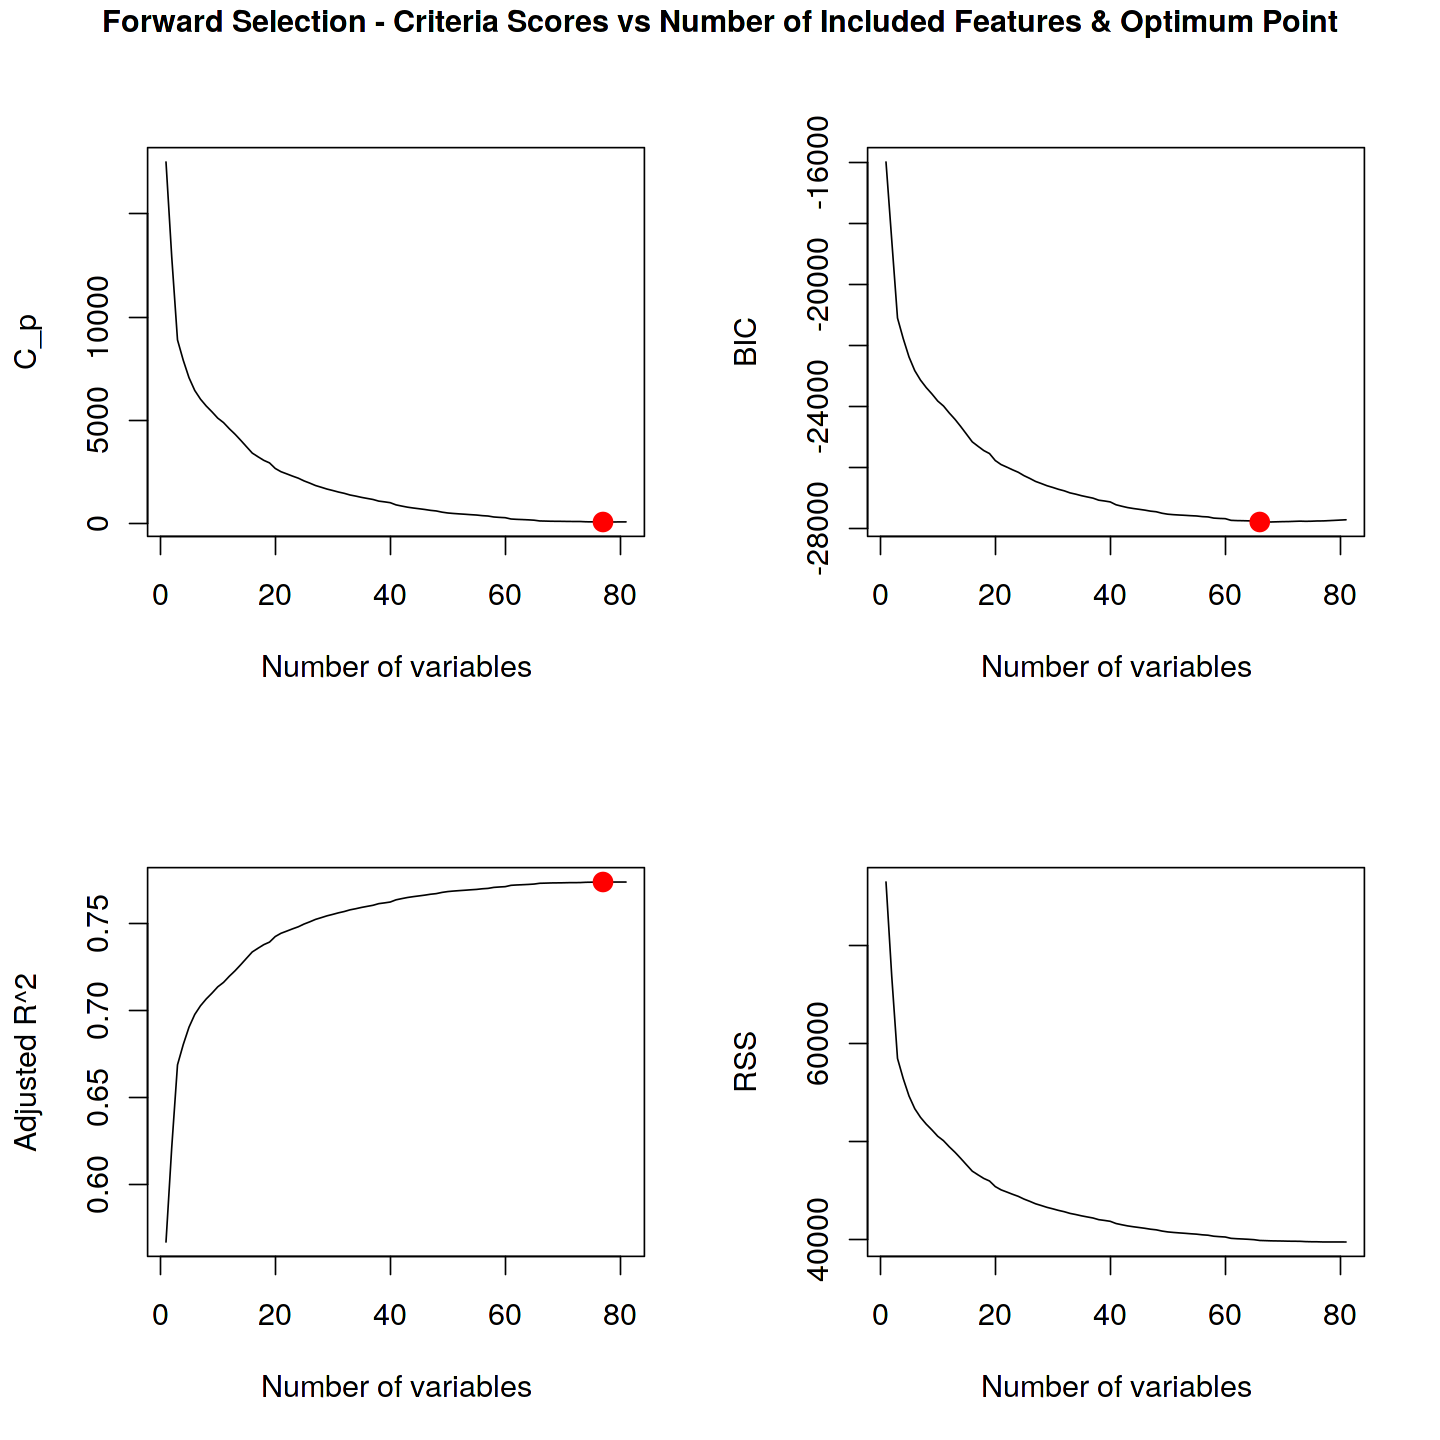

In [19]:
# Draw results of regsubsets
par(mfrow = c(2, 2), cex = 1.5, cex.main = 1.5)
plot(reg.summary.fwd$cp, xlab = "Number of variables", ylab = "C_p", type = "l")
points(which.min(reg.summary.fwd$cp), reg.summary.fwd$cp[which.min(reg.summary.fwd$cp)], 
       col = "red", cex = 2, pch = 20)

plot(reg.summary.fwd$bic, xlab = "Number of variables", ylab = "BIC", type = "l")
points(which.min(reg.summary.fwd$bic), reg.summary.fwd$bic[which.min(reg.summary.fwd$bic)],
       col = "red", cex = 2, pch = 20)

plot(reg.summary.fwd$adjr2, xlab = "Number of variables", ylab = "Adjusted R^2", type = "l")
points(which.max(reg.summary.fwd$adjr2), reg.summary.fwd$adjr2[which.max(reg.summary.fwd$adjr2)],
       col = "red", cex = 2, pch = 20)

plot(reg.summary.fwd$rss, xlab = "Number of variables", ylab = "RSS", type = "l")
mtext("Forward Selection - Criteria Scores vs Number of Included Features & Optimum Point", line = -1, outer = TRUE, cex=1.5, font=2)

cat("Number of predictors for Minimum C_p:",which.min(reg.summary.fwd$cp))
cat("\nNumber of predictors for Minimum BIC:",which.min(reg.summary.fwd$bic))
cat("\nNumber of predictors for Maximum adj_R2:",which.max(reg.summary.fwd$adjr2))

- Adjusted R^2 and C_p suggest to keep all of the predictors.

- RSS always decreases with increasing number of predictors. Therefore, it doesn't suggest a specific number of variables though, amount of decrease don't seem significant until the right end of the graph that can be interpreted as a sign to eliminate some of the predictors in the model.

- BIC has its lowest value when there are 76 variables. Therefore, one model will be created according to BIC's suggestion and it will be compared with full model.
<a id="section3.1.1"></a>
### 3.1.1 Test Error of BIC - Cp - Adj_R^2 Models

In [20]:
# Make predictions on test set and print RMSE
bic_coef.fwd = coef(regfit.fwd, which.min(reg.summary.fwd$bic))
pred_names = names(bic_coef.fwd)
test.mat = model.matrix(critical_temp~., data = test)
pred = test.mat[,pred_names]%*%bic_coef.fwd
pred = pred^2
cat("RMSE of Step Forward BIC Model: ",RMSE(pred,test[,82]))

# Make predictions on test set and print RMSE
cp_coef.fwd = coef(regfit.fwd, which.min(reg.summary.fwd$cp))
pred_names = names(cp_coef.fwd)
test.mat = model.matrix(critical_temp~., data = test)
pred = test.mat[,pred_names]%*%cp_coef.fwd
pred = pred^2
cat("\nRMSE of Step Forward Cp Model: ",RMSE(pred,test[,82]))

# Make predictions on test set and print RMSE
adjr2_coef.fwd = coef(regfit.fwd, which.max(reg.summary.fwd$adjr2))
pred_names = names(adjr2_coef.fwd)
test.mat = model.matrix(critical_temp~., data = test)
pred = test.mat[,pred_names]%*%adjr2_coef.fwd
pred = pred^2
cat("\nRMSE of Step Forward Adjusted R^2 Model: ",RMSE(pred,test[,82]))

RMSE of Step Forward BIC Model:  16.67292
RMSE of Step Forward Cp Model:  16.67039
RMSE of Step Forward Adjusted R^2 Model:  16.67039

- Because Adjusted R^2 and Cp suggest the same model (i.e 81 predictors), they gave the same test error as expected.

- BIC's model ended up with a 0.04 RMSE higher than the others though it has 5 predictors less than the others.
<a id="section3.1.2"></a>
### 3.1.2 Assessing Feature Importance

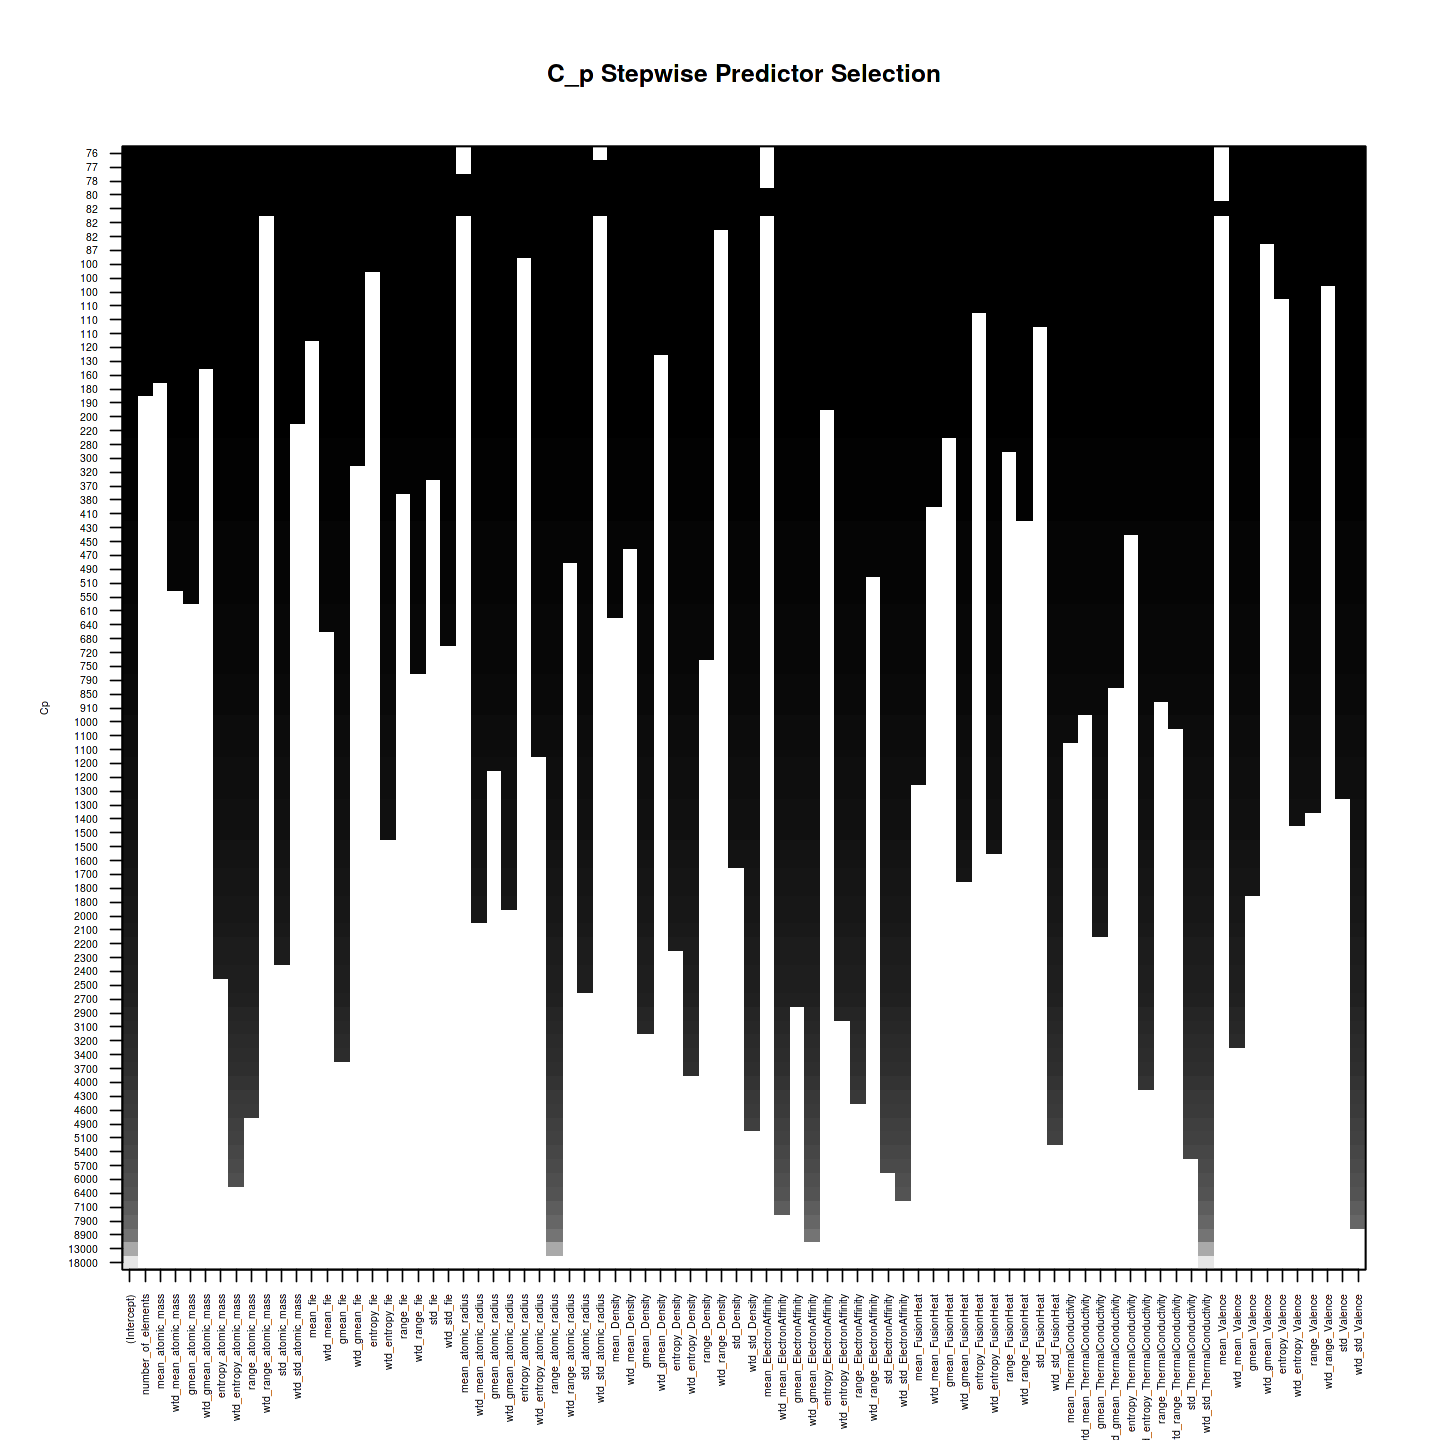

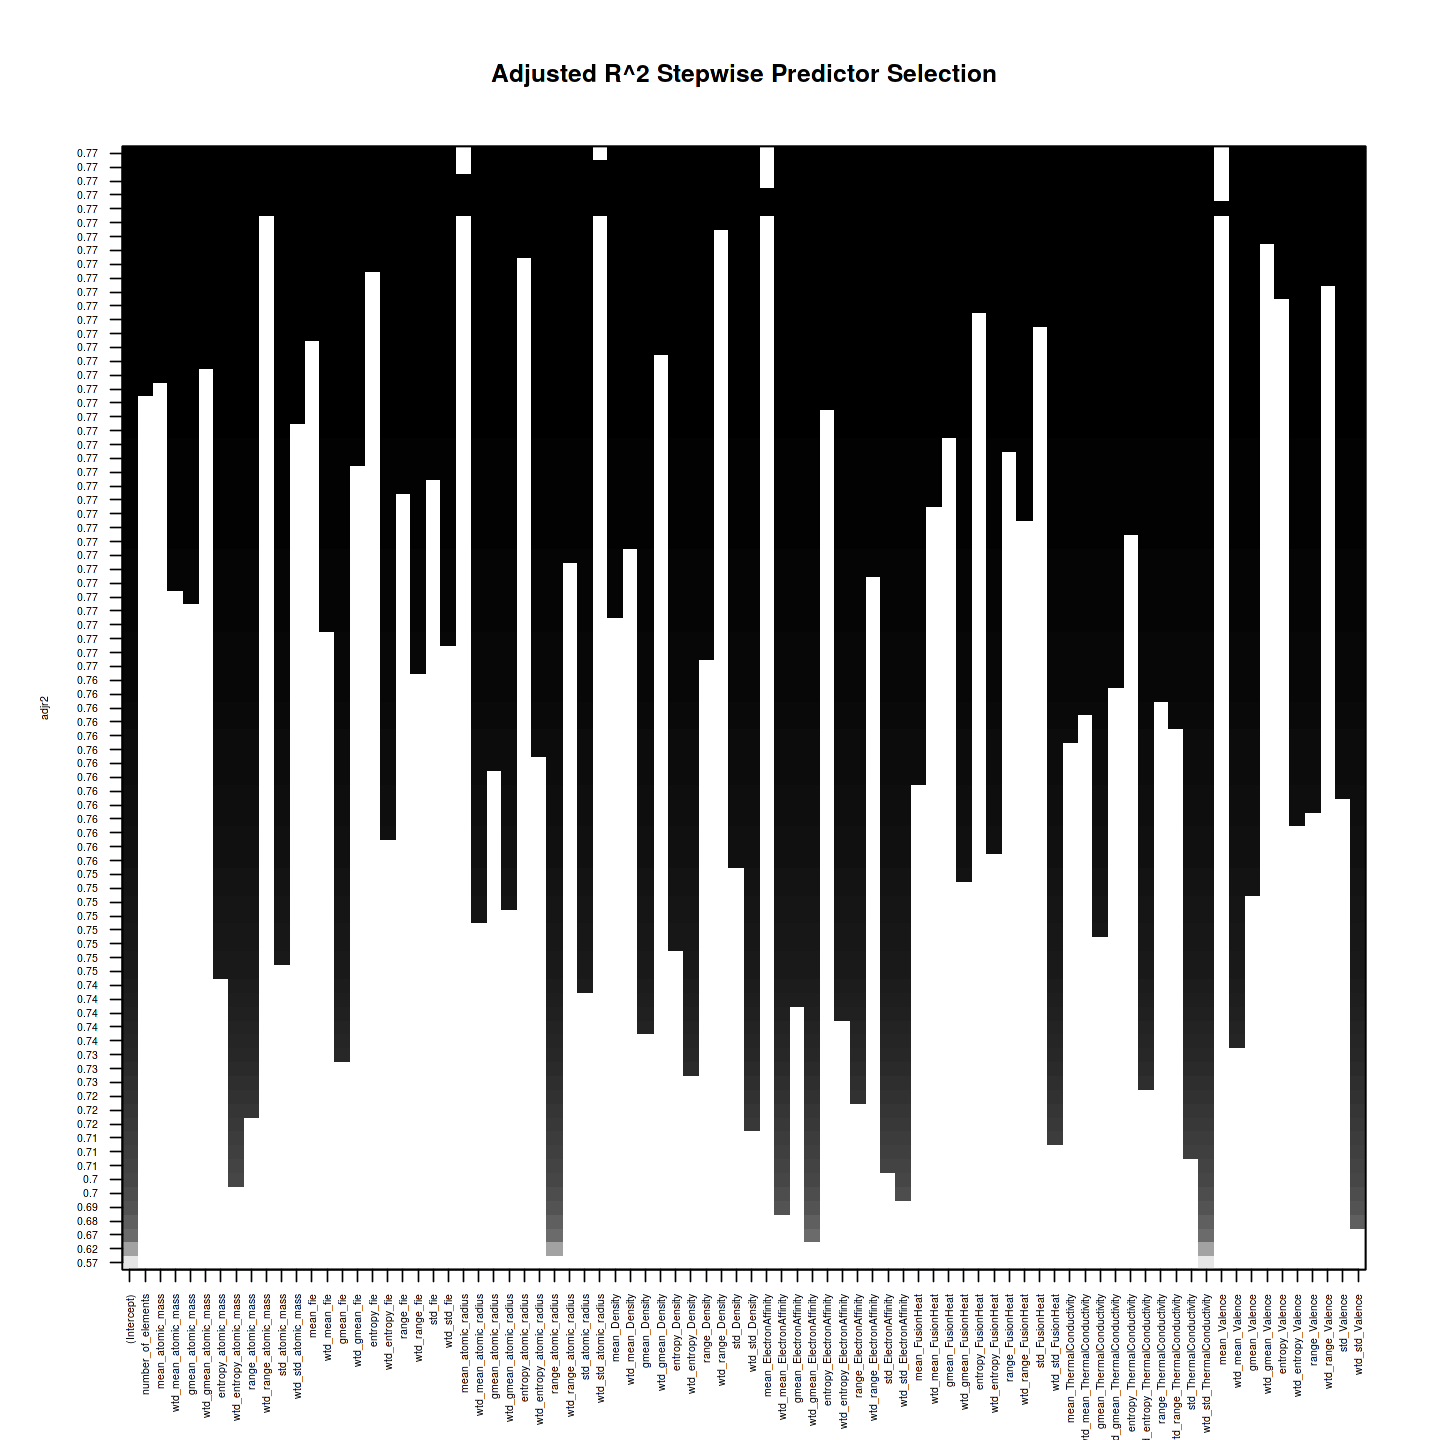

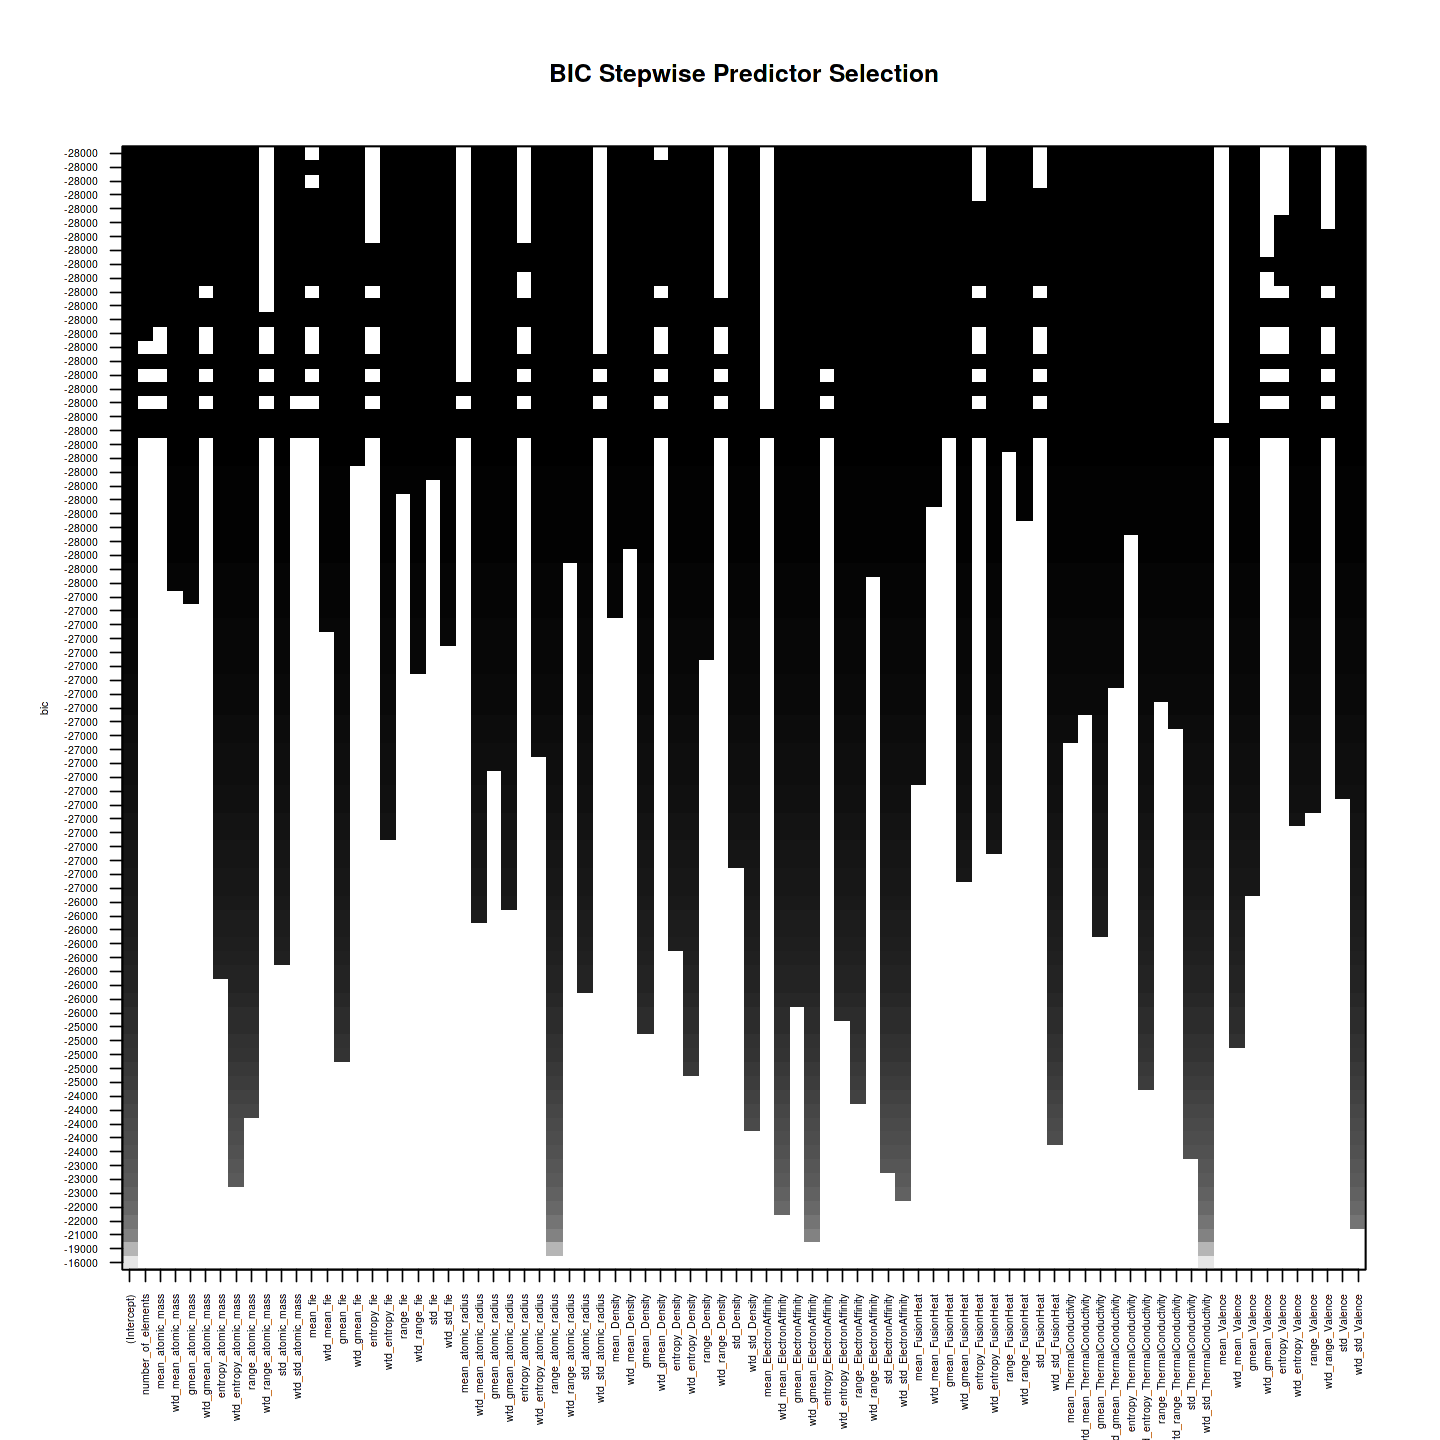

In [21]:
# Draw the stepwise selection process
par(cex.axis=.5, cex.lab=.5)
plot(regfit.fwd, main="C_p Stepwise Predictor Selection", scale="Cp",
 col=gray(seq(0, 0.9, length = 100)),cex.axis=0.1)

# Draw the stepwise selection process
par(cex.axis=.5, cex.lab=.5)
plot(regfit.fwd, main="Adjusted R^2 Stepwise Predictor Selection", scale="adjr2",
 col=gray(seq(0, 0.9, length = 100)),cex.axis=0.1)

# Draw the stepwise selection process
par(cex.axis=.5, cex.lab=.5)
plot(regfit.fwd, main="BIC Stepwise Predictor Selection", scale="bic",
 col=gray(seq(0, 0.9, length = 100)))

According to stepwise predictor selection procedures visualised above, top 5 predictors that most contributes to prediction performance according to BIC, adjusted R^2 and C_p are same and as follows;
1. wtd_std_ThermalConductivity
2. range_atomic_radius
3. wtd_gmean_ElectrionAffinity
4. wtd_std_Valance
5. wtd_mean_ElectronAffinity

Apart from individual features, by looking general patterns of the graphs, we can rank the chemical properties (such as Atomic Mass) according to their contribution to predictive performance. In graph, features of a certain chemical property are located together which allows us to rank them by visuall inspection.

_According to BIC, adjusted R^2 and Cp ;_

__1. Electron Affinity :__ Most of the lines are about to touch to X axis around Electron Affinity measures, that makes electron affinity the one property of the substance that makes the most significant impact on the prediction of critical temperature.

__2. Thermal Conductivity :__ According to result of forward selection procedure, Thermal conductivity should be the second important predictor for prediction of critical temperature.

Other 3 important predictor properties are **Atomic Radius, Atomic Mass, Valance**
<a id="section3.2"></a>
## 3.2 Ridge Regression (L1)

In [22]:
# Create test and training matrix
train.mat <- model.matrix(sqrt(critical_temp) ~ ., data = train)[,-1]
test.mat <- model.matrix(sqrt(critical_temp) ~ ., data = test)[,-1]
# Create grid for hyper parameter tuning
grid <- 10^seq(4, -2.5, length = 100)

# Find the best lambda & train the model
set.seed(1)# the purpose of fixing the seed of the random number generator is to make the result repeatable.
fit.ridge <- glmnet(train.mat, sqrt(train$critical_temp), alpha = 0, lambda = grid, thresh = 1e-12)
cv.ridge <- cv.glmnet(train.mat, sqrt(train$critical_temp), alpha = 0, lambda = grid, thresh = 1e-12)
bestlam.ridge <- cv.ridge$lambda.min
cat("Best performing lambda value for Ridge according to applied cross-validation",bestlam.ridge)

# Make predictions on test set
pred.ridge <- (predict(fit.ridge, s = bestlam.ridge, newx = test.mat))^2
cat("\nMSE of the model using Ridge parameter shrinkage",RMSE(pred.ridge,test[,82]))

Best performing lambda value for Ridge according to applied cross-validation 0.003162278
MSE of the model using Ridge parameter shrinkage 16.84866

<a id="section3.3"></a>
## 3.3 LASSO (L2)

In [23]:
# Find the best lambda & train the model
set.seed(1)# the purpose of fixing the seed of the random number generator is to make the result repeatable.
fit.lasso <- glmnet(train.mat, log(train$critical_temp), alpha = 1, lambda = grid, thresh = 1e-12)
cv.lasso <- cv.glmnet(train.mat, log(train$critical_temp), alpha = 1, lambda = grid, thresh = 1e-12)
bestlam.lasso <- cv.lasso$lambda.min
cat("Best performing lambda value for Lasso according to applied cross-validation",bestlam.lasso)
cat("\nNumber of predictors that Lasso excluded from the full model: ",
    sum(predict(fit.lasso, s = bestlam.lasso, type = "coefficients")==0))

# Make predictions on test set
pred.lasso <- (predict(fit.lasso, s = bestlam.lasso, newx = test.mat))^2
cat("\nMSE of the model using Lasso parameter shrinkage",RMSE(pred.lasso,test[,82]))

Best performing lambda value for Lasso according to applied cross-validation 0.003162278
Number of predictors that Lasso excluded from the full model:  34
MSE of the model using Lasso parameter shrinkage 38.6618

<a id="section3.4"></a>
## 3.4 Comparing Results of Stepwise Selections and Parameter Shrinkage

__Stepwise Selection BIC:__ BIC reached its lowest value with 76 predictors.
RMSE on test set is __16.87109__ for forward selection with BIC.

__Stepwise Selection Cp and Adjusted R^2:__ Both of them suggested to use model with 81 predictors. Hence, they suggested the same model and the RMSE values are same consequently.
RMSE on test set is __16.83296__ for forward selection with Adjusted R^2 and Cp.


__Parameter Shrinkage using Ridge__: Ridge didn't assign 0 coefficient to any predictors which means its model included 81 predictors.
RMSE on test set is __17.01915__ for the model with Ridge parameter shrinkage.

__Parameter Shrinkage using Lasso__: As expected, Lasso excluded some of the predictors. It ended up with 60 predictors including factors.
RMSE on test set is __39.09433__ for the model with Lasso parameter shrinkage.


**Starting with all 81 predictors and applying subset selection and parameter shrinkage methods above models are obtained. 
Best predictive performance is observed when all the features are included as suggested by Adj_R^2 and C_p. Therefore, final regression model will be the one with all the predictors.**

In [24]:
# Final regression model is the one with all predictors
final_reg = fit3

<a id="section4"></a>
# 4. XGBoost

In [25]:
# Load the datasets
data=read.csv("../input//super-conductors/train.csv")

nrow = dim(data)[1]
ncol = dim(data)[2]

# Divide dataset into test and train
set.seed(0)
test.index = sample(1:nrow, round(nrow/3), replace = FALSE)
train = data[-test.index, ]
test = data[test.index,]

# Seperate labels
train_data = as.matrix(train[,-82])
train_label = train[,82]

test_data = as.matrix(test[,-82])
test_label = test[,82]



# Convert into Dmatrix for XGBoost
dtrain <- xgb.DMatrix(data = train_data, label= train_label)
dtest <- xgb.DMatrix(data = test_data, label= test_label)

<a id="section4.1"></a>
## 4.1 Cross-Validation for XGBoost

In [26]:
# xgboost fitting with arbitrary parameters
params = list(
  objective = "reg:squarederror", # Optimise on Squared Error in regression
  eta = 0.1,                     # learning rate
  max.depth = 3,                  # Max depth of each decision tree
  eval_metric = "rmse"             # Root-Mean-Squared-Error
)


# cross-validate xgboost to get the accurate measure of error
xgb_cv = xgb.cv(params = params,
                  data = dtrain,
                  nrounds = 200, 
                  nfold = 5,                                                   # number of folds in K-fold
                  prediction = TRUE,                                           # return the prediction using the final model 
                  early_stop_round = 3,
                  verbose=FALSE
)

# Exclude std. columns
xgb_cv = xgb_cv$evaluation_log %>% select(-contains("std")) %>% melt(id=c("iter"))

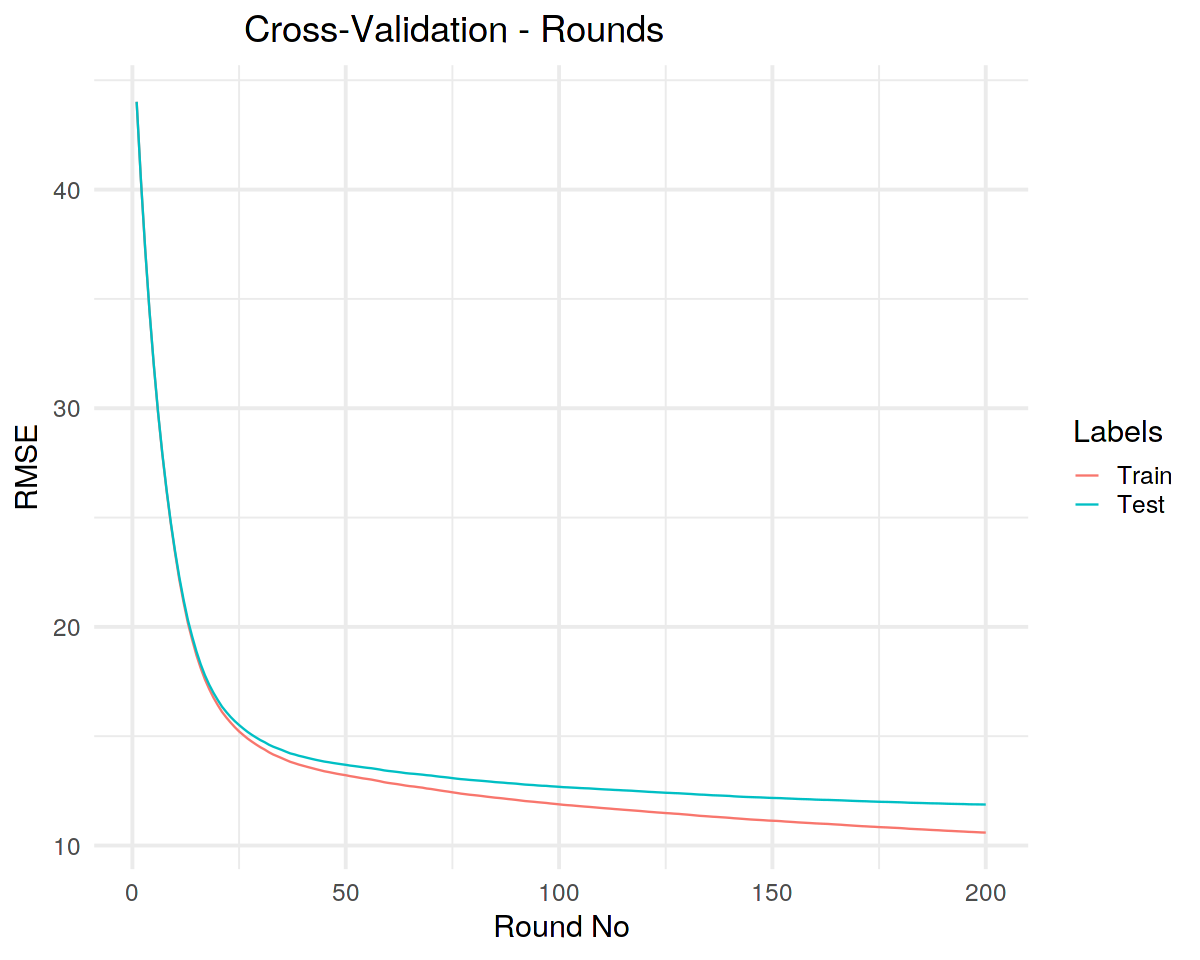

In [27]:
# Size the plot
options(repr.plot.width=10, repr.plot.height=8)
# Plot Train & Test Error
ggplot(xgb_cv, aes(x=iter, y=value,col=variable)) + geom_line() +theme_minimal(base_size = 18) +
xlab("Round No") + ylab("RMSE") + ggtitle("               Cross-Validation - Rounds") + 
scale_color_discrete(name = "Labels", labels = c( "Train", "Test"))

<a id="section4.2"></a>
## 4.2 XGBoost Hyper-Parameter Tuning with Grid-Search

Lowest RMSE giving eta:  0.1
Lowest RMSE giving max_depth:  6

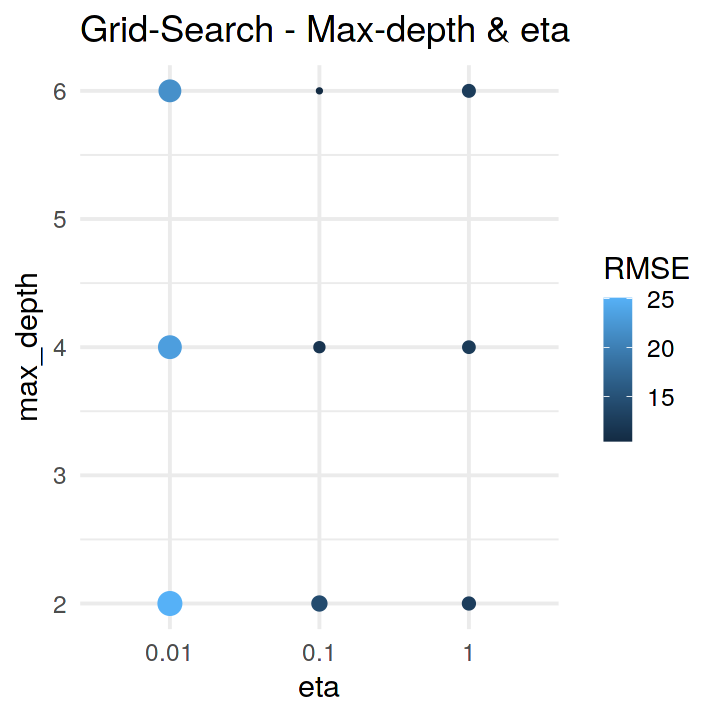

In [28]:
# set up the cross-validated hyper-parameter search grid
grid = expand.grid(
  nrounds = 100,
  eta = c(1, 0.1, 0.01),
  max_depth = c(2, 4, 6),
    gamma = 0,
    colsample_bytree=1,
    min_child_weight = 2,
    subsample = 1
    
)

# Set train control parameters
cont_params = trainControl(
  method = "cv",                     
  number = 5,                 # Number of Folds in CV
  verboseIter = FALSE,
  returnData = FALSE,
  returnResamp = "all",       # save losses across all models
)


# train XGBoost models for each parameter combination in the grid
xgb_tuning = train(
  x = train_data,
  y = train_label,
  trControl = cont_params,
  tuneGrid = grid,
  method = "xgbTree"
)

# Size the plot
options(repr.plot.width=6, repr.plot.height=6)

# Plot of the RMSE against hyper-parameters max_depth and eta 
ggplot(xgb_tuning$results, aes(x = as.factor(eta), y = max_depth, size = RMSE, color = RMSE)) + 
  geom_point() + 
  theme_minimal(base_size = 18) + 
  xlab("eta") +
  scale_size_continuous(guide = "none") + ggtitle("Grid-Search - Max-depth & eta")

cat("Lowest RMSE giving eta: ",xgb_tuning$bestTune$eta)
cat("\nLowest RMSE giving max_depth: ",xgb_tuning$bestTune$max_depth)

In [29]:
xgb_model <- xgb.train(objective = "reg:squarederror",    # Optimise on Squared Error in regression
                  eta = 0.1,                        # learning rate
                  max.depth = 6,                  # Max depth of each decision tree
                  eval_metric = "rmse",
                  data = dtrain,
                  nrounds = 250,                    # Number of trees to create
                  nfold = 5,                        # number of folds in K-fold
                  early_stop_round = 3,              # Stop, if no improvement 3 consequtive rounds
                  verbosa=0
)

<a id="section4.3"></a>
## 4.3 Assessing Feature Importance

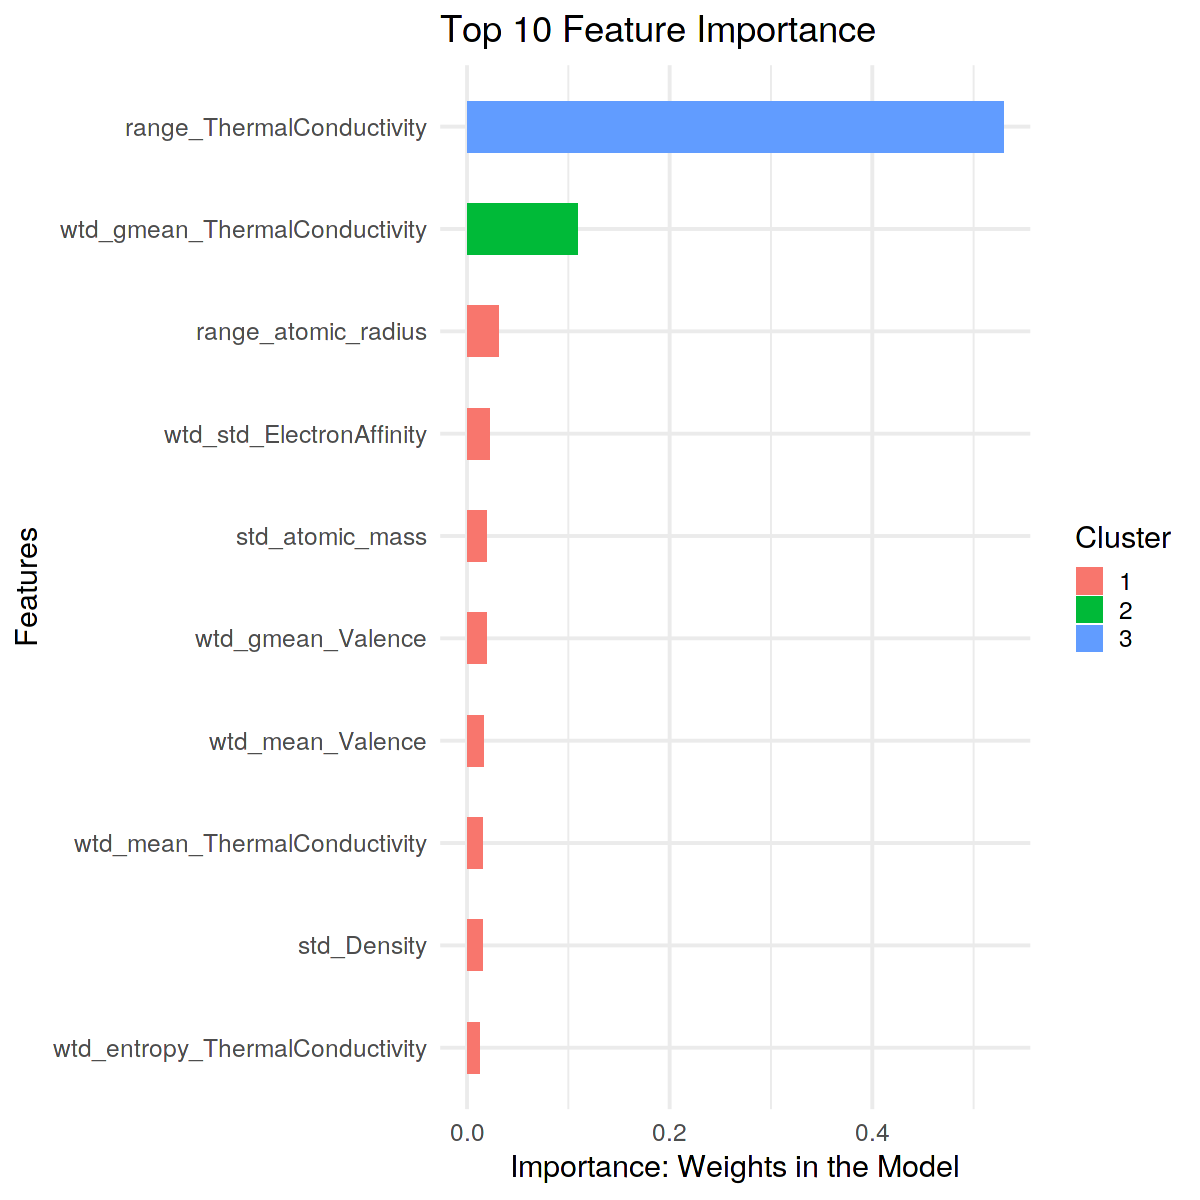

In [30]:
# get the importance of features
importance_mat = xgb.importance(colnames(dtrain), model = xgb_model)
# Size the plot
options(repr.plot.width=10, repr.plot.height=10)
# Draw the bar plot of feature importance
xgb.ggplot.importance(importance_mat, top_n = 10) + theme_minimal(base_size = 18) +
ggtitle("Top 10 Feature Importance") + ylab("Importance: Weights in the Model")

- range_Thermal_Conductivity and wtd_gmean_Thermal_Conductivity are governing the XGBoost model.
- In terms of chemical properties, Thermal conductivity and density are affective on the critical temperature of a superconductor according to XGBoost model.

**These results are consistent with the ones found using regression models. Especially Thermal conductivity is the most important checmical property according to all of the created models.**

<a id="section5"></a>
# 5. Model Comparison

In [31]:
# Make predictions on test set and print RMSE
regression_pred=(predict(final_reg, as.data.frame(test_data)))^2
cat("RMSE of Final Regression Model: ",RMSE(regression_pred,test_label),
    "; which is ",RMSE(regression_pred,test_label)*100/mean(test_label),
    "% of the mean critical temperature")

xgb_pred = (predict(xgb_model, dtest))
cat("\nRMSE of Tuned XGBoost Model: ",RMSE(xgb_pred,test_label),
    "; which is ",RMSE(xgb_pred,test_label)*100/mean(test_label),
    "% of the mean critical temperature")



RMSE of Final Regression Model:  16.92545 ; which is  48.73634 % of the mean critical temperature
RMSE of Tuned XGBoost Model:  9.704984 ; which is  27.94522 % of the mean critical temperature

**RMSE:** By looking at RMSE, XGBoost model deviates from the actual critical temperature 9.7 on average for test set whereas RMSE is 16.9 for regression. Also, these values can be evaluated according to average critical temperature. For this case regression model deviates 48%  of the mean critical temperature for a prediction on average. XGBoost decision trees 27%  suggesting that XGBoost has a better predictive performance than the model created with regression.


**All in all, by looking at above results, Model created using XGBoost outperforms the all other developed model in this notebook.**